In [4]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)


# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [69]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn import selection

RUN_LANGDETECT = False

# Run time-consuming grid searches
RUN_SWEEPS = frozenset()

FIT_MODELS = frozenset({"svm_1", "svm_2", "svm_3"})

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

# Data Preparation

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=[
        "text",
        "title",
        "brand",
        "main_cat",
    ],
)
display(df.head())
df.shape

text  \
asin                                                            
1441072241  come tell me how you lived: native american hi...   
6090113980  prayer rug carpet mat gebetsteppich islamic mu...   
7250468162  no7 stay perfect foundation cool vanilla by no...   
8279996397  imagen bendita por su santidad our lady of cha...   
9197882747  hall of femmes: lella vignelli (hall of femmes...   

                                                        title  \
asin                                                            
1441072241  come tell me how you lived: native american hi...   
6090113980  prayer rug carpet mat gebetsteppich islamic mu...   
7250468162    no7 stay perfect foundation cool vanilla by no7   
8279996397  imagen bendita por su santidad our lady of cha...   
9197882747    hall of femmes: lella vignelli (hall of femmes)   

                      brand    main_cat  
asin                                     
1441072241  enter the arena  all beauty  
6090113980       bonballoon  all beauty  
7250468162              no7  all beauty  
8279996397           chango  all beauty  
9197882747     oyster press  all beauty

(3878957, 4)

<IPython.core.display.Javascript object>

In [4]:
cleaning.info(df)

null  null_%     uniq  uniq_%    dup  dup_%
text         0     0.0  3788215   97.66  90742   2.34
title        0     0.0  3759140   96.91  90742   2.34
brand        0     0.0   844433   21.77  90742   2.34
main_cat     0     0.0       37    0.00  90742   2.34

<IPython.core.display.Javascript object>

In [5]:
df = df.loc[~df.index.duplicated()]
df.shape

(3788215, 4)

<IPython.core.display.Javascript object>

## Refining the Brands

I begin with the brand terms, which will be very important for the classifier.

In [6]:
empty_brand = df.loc[df.brand.str.fullmatch("\s*")]
empty_brand

text  \
asin                                                            
B000050B67  norelco 5655x deluxe advantage wet/dry cordles...   
B000050B69  norelco t7500 deluxe cord/cordless rechargeabl...   
B000050FDP  braun 6520 flex integral ultra speed rechargea...   
B000052YD8  scope original mint mouthwash 50.7 fl oz. scop...   
B00005336W  dove nutrium nutrient beads nourishing body wa...   
...                                                       ...   
B01H0UDFXQ  marc lawrence's 2016 playbook football preview...   
B01H3U5GNA  american original soft and cozy coastal stripe...   
B01H87P6YM  hitachi 43in 2160p 120hz 4k uhd led tv. the ne...   
B01HB59462  hanging chaise lounger chair arc stand air por...   
B01HCAUSG6  elizabeth jane howard cazalet chronicles 5 boo...   

                                                        title brand  \
asin                                                                  
B000050B67  norelco 5655x deluxe advantage wet/dry cordles...         
B000050B69  norelco t7500 deluxe cord/cordless rechargeabl...         
B000050FDP  braun 6520 flex integral ultra speed rechargea...         
B000052YD8           scope original mint mouthwash 50.7 fl oz         
B00005336W  dove nutrium nutrient beads nourishing body wa...         
...                                                       ...   ...   
B01H0UDFXQ     marc lawrence's 2016 playbook football preview         
B01H3U5GNA  american original soft and cozy coastal stripe...         
B01H87P6YM             hitachi 43in 2160p 120hz 4k uhd led tv         
B01HB59462  hanging chaise lounger chair arc stand air por...         
B01HCAUSG6  elizabeth jane howard cazalet chronicles 5 boo...         

              main_cat  
asin                    
B000050B67  all beauty  
B000050B69  all beauty  
B000050FDP  all beauty  
B000052YD8  all beauty  
B00005336W  all beauty  
...                ...  
B01H0UDFXQ       books  
B01H3U5GNA       books  
B01H87P6YM       books  
B01HB59462       books  
B01HCAUSG6       books  

[161844 rows x 4 columns]

<IPython.core.display.Javascript object>

Looks like there are over about 1.6 million empty brand entries. I'll replace those with 'none' for now.

In [7]:
df.loc[empty_brand.index, "brand"] = "none"
df.loc[df.brand.str.fullmatch("\s*")]

Empty DataFrame
Columns: [text, title, brand, main_cat]
Index: []

<IPython.core.display.Javascript object>

In [8]:
del empty_brand

<IPython.core.display.Javascript object>

Next, I'm going to tokenize the brands using the default Scikit-Learn tokenizer regex (r'\b\w\w+\b'). This is the default value for 'token_pattern' in `CountVectorizer`, `HashingVectorizer`, and `TfidfVectorizer`.

I like the default Scikit-Learn tokenizer because it ignores punctuation and grabs sequences of 2 or more word characters (within word boundaries). It strips out most of the noise in a single stroke.

I define a function below using this pattern.

In [9]:
def sklearn_tokenize(docs, n_jobs=None):
    pattern = re.compile(r"\b\w\w+\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

It's a short function, but a powerful one. It's **polymorphic**, meaning that it it behaves differently depending on the input type. If `docs` is a string, it simply returns the list of tokens. However, if `docs` is a container type like `Series` or `DataFrame`, it applies the tokenizer to every element. It also features **multiprocessing**, which dramatically improves performance on large datasets like this one.

Like many functions you'll see this notebook, it uses the infrastructure provided by my low-level function `lang.process_strings`.

In [10]:
help(lang.process_strings)

Help on function process_strings in module tools.language.utils:

process_strings(strings: Union[str, Iterable[str]], func: Callable[[str], Any], n_jobs: int = None, **kwargs) -> Any
    Apply `func` to a string or iterable of strings (elementwise).
    
    Most string filtering/processing functions in the language module
    are polymorphic, capable of handling either a single string or an
    iterable of strings. Whenever possible, they rely on this generic
    function to apply a callable to string(s). This allows them to
    behave polymorphically and take advantage of multiprocessing while
    having a simple implementation.
    
    This is a single dispatch generic function, meaning that it consists
    of multiple specialized sub-functions which each handle a different
    argument type. When called, the dispatcher checks the type of the first
    positional argument and then dispatches the sub-function registered
    for that type. In other words, when the function is called,

<IPython.core.display.Javascript object>

Another lower-level function you'll see is `lang.chain_processors`, which allows me to apply a function-pipeline to string(s). This is especially useful when I need to tokenize some strings, do something, and then detokenize them. In the following cell, I coerce the brand names to ASCII, tokenize them, and then immediately detokenize them. I want to reduce the number of unique values by reducing the number of near-duplicates.

In [11]:
# Function pipeline given as a list
steps = [lang.force_ascii, sklearn_tokenize, "_".join]

# Apply pipeline using all available cores
df["brand"] = lang.chain_processors(df.loc[:, "brand"], steps, n_jobs=-1)

df["brand"].value_counts()

none                   161849
generic                 10368
yu_gi_oh                 7091
magic_the_gathering      6536
invicta                  5974
                        ...  
buck_wild                   1
violeta_guerra              1
dee_edgeworth               1
john_drabinski              1
chris_boal                  1
Name: brand, Length: 792830, dtype: int64

<IPython.core.display.Javascript object>

Over 790,000 unique brands! I'm going to use the brands as ngram phrases in the text, but I suspect most of these are too obscure to be useful. One-off brand terms are almost completely useless for a term-frequency-based classification, since they'll only appear in one vector.

In [12]:
def plot_brand_counts(data, brand_col="brand", bins=100, log_scale=True):
    brand_counts = data[brand_col].value_counts()
    g = sns.displot(
        data=brand_counts.to_frame(),
        x=brand_col,
        log_scale=log_scale,
        bins=bins,
        aspect=2,
    )
    g.axes[0, 0].set(
        xlabel="Number of Products",
        ylabel="Number of Brands",
        title="Number of Products by Brand",
    )
    g.axes[0, 0].xaxis.set_major_formatter(plotting.big_number_formatter())
    g.axes[0, 0].yaxis.set_major_formatter(plotting.big_number_formatter())

<IPython.core.display.Javascript object>

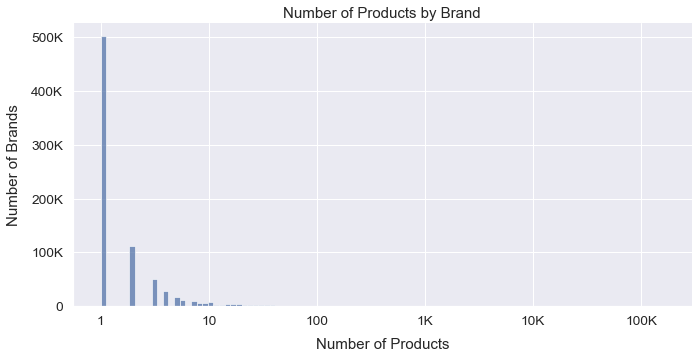

<IPython.core.display.Javascript object>

In [13]:
plot_brand_counts(df)

Over 500,000 brands have just one instance. I'm not interested in those.

In order to engineer a solid dataset for product classification, I'm going to keep only the biggest brands in each main category. That ought to get rid of most of the brand noise and make room for some signal.

For each main category, (with some exceptions) I keep only the top 1% of brands. Again, I'm measuring brand size in terms of number of products. Main categories with less than 1,000 samples are exempt from the pruning. Furthermore, all *none* entries will be dropped except in categories which are almost entirely *none* (in order to preserve the categories). The 'fine art' category, for instance, is ~99% *none*, presumably due to the unique nature of the products. Currently Amazon does show brands for fine art products, but that may have been different in 2018, when this data was collected.

In [14]:
# Drop brands below this quantile
qcut = 0.99
# Keep nulls in null-dominated categories
retain_nulls = ["fine art", "luxury beauty", "handmade"]
# Don't prune small categories
protected_thresh = 1000

pruned_df = []

for cat, group in df.groupby("main_cat"):
    if group.shape[0] <= protected_thresh:
        pruned_df.append(group)
        continue
    if cat not in retain_nulls:
        group = group.loc[group.brand != "none"]
    print(cat)
    print("-" * len(cat))
    group = utils.prune_categories(group, "brand", qcut=qcut)
    print("\n")
    pruned_df.append(group)

pruned_df = pd.concat(pruned_df)

all beauty
----------
                               Status  Support
crystalage                   retained       89
makingcosmetics              retained       80
kroo                         retained       70
crest                        retained       63
vktech                       retained       61
...                               ...      ...
finally_natural_care          dropped        1
dead_sea_spa_care             dropped        1
ridgeyard_co_ltd              dropped        1
bombshell_bath_bomb_boudoir   dropped        1
keller_international          dropped        1

[5208 rows x 2 columns]


all electronics
---------------
                Status  Support
sony          retained     1199
panasonic     retained     1134
samsung       retained      880
startech      retained      528
generic       retained      520
...                ...      ...
crown_awards   dropped        1
cosori         dropped        1
print4ever     dropped        1
aero_phoenix   dropped        1
cha

[24551 rows x 2 columns]


handmade
--------
                         Status  Support
none                   retained     2218
marvel                  dropped        3
apple                   dropped        2
monster                 dropped        2
brenda_elaine_jewelry   dropped        1
lego                    dropped        1


health & personal care
----------------------
                        Status  Support
maxiaids              retained      139
liliane_memorials     retained      131
crystalage            retained      115
terravita             retained       89
big_dot_of_happiness  retained       88
...                        ...      ...
amber_lyn              dropped        1
bellman                dropped        1
tether_tools           dropped        1
pharmaton              dropped        1
accelerade             dropped        1

[10311 rows x 2 columns]


home audio & theater
--------------------
                           Status  Support
sony                     re

[3229 rows x 2 columns]




<IPython.core.display.Javascript object>

In [15]:
size_reduct = 1 - (len(pruned_df) / len(df))
print(f"Reduced n_samples by {size_reduct:.0%}")
pruned_df

Reduced n_samples by 71%


text  \
asin                                                            
B000050AUH  philips sonicare standard brush head. sonic wa...   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   
...                                                       ...   
B01HH6JEOC  the sims 4 kids room stuff [online game code]....   
B01HIU43S4  1k games sega mega drive game console with wir...   
B01HIZF83S  bioshock: the collection - playstation 4. retu...   
B01HJ149LI  god eater resurrection - ps vita [digital code...   
B01HJ14FDA  jojo eyes of heaven complete bundle - ps4 [dig...   

                                                        title  \
asin                                                            
B000050AUH               philips sonicare standard brush head   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   
...                                                       ...   
B01HH6JEOC      the sims 4 kids room stuff [online game code]   
B01HIU43S4  1k games sega mega drive game console with wir...   
B01HIZF83S           bioshock: the collection - playstation 4   
B01HJ149LI    god eater resurrection - ps vita [digital code]   
B01HJ14FDA  jojo eyes of heaven complete bundle - ps4 [dig...   

                       brand     main_cat  
asin                                       
B000050AUH  philips_sonicare   all beauty  
B000050B62           norelco   all beauty  
B000050B63           norelco   all beauty  
B000050B64           norelco   all beauty  
B000050B65           norelco   all beauty  
...                      ...          ...  
B01HH6JEOC   electronic_arts  video games  
B01HIU43S4              sega  video games  
B01HIZF83S                2k  video games  
B01HJ149LI            bandai  video games  
B01HJ14FDA            bandai  video games  

[1091412 rows x 4 columns]

<IPython.core.display.Javascript object>

In [16]:
pruned_df.brand.nunique()

9748

<IPython.core.display.Javascript object>

This is an enormous dataset, so the top 1% of brands in each category leaves me with ~10k brands. That's a fairly large, yet manageable, number.

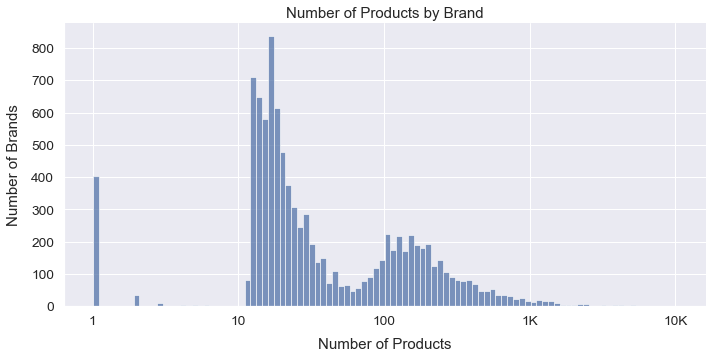

<IPython.core.display.Javascript object>

In [17]:
plot_brand_counts(pruned_df)

Although I only took the top 1% of brands in each category, most of the brands have 10-50 products. That seems like a healthy number.

The histogram also shows that there are ~400 single-product brands from the protected categories. That's fine. Those terms won't be very useful, but there's plenty of other useful information in those categories.

In [18]:
pruned_df.main_cat.value_counts()

amazon home                     170130
amazon fashion                  126160
books                           119701
toys & games                     97824
sports & outdoors                80179
tools & home improvement         79987
automotive                       66913
cell phones & accessories        56983
grocery                          39390
computers                        33940
all electronics                  24930
office products                  24438
camera & photo                   21183
arts, crafts & sewing            18418
industrial & scientific          18388
digital music                    18088
pet supplies                     16215
home audio & theater             15117
musical instruments              13457
video games                      11297
movies & tv                      10468
luxury beauty                     6452
health & personal care            3682
software                          3655
car electronics                   3229
baby                     

<IPython.core.display.Javascript object>

In [19]:
df = pruned_df
df.head()

text  \
asin                                                            
B000050AUH  philips sonicare standard brush head. sonic wa...   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   

                                                        title  \
asin                                                            
B000050AUH               philips sonicare standard brush head   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   

                       brand    main_cat  
asin                                      
B000050AUH  philips_sonicare  all beauty  
B000050B62           norelco  all beauty  
B000050B63           norelco  all beauty  
B000050B64           norelco  all beauty  
B000050B65           norelco  all beauty

<IPython.core.display.Javascript object>

In [20]:
df.groupby("main_cat").get_group("arts, crafts & sewing").brand.value_counts()

lantern_press               1030
3drose                       812
beadaholique                 780
sizzix                       688
spellbinders                 593
                            ... 
sparkles_make_it_special      82
vogue_fabrics                 81
azeeda                        80
craftbuddy_us                 80
susan_bates                   80
Name: brand, Length: 97, dtype: int64

<IPython.core.display.Javascript object>

## Engineering the Vocabulary

I engineer the model's vocabulary by preprocessing the text, developing a custom tokenizer, and constructing multi-word expressions. The purpose of the model is to assimilate novel products into Amazon's existing classification scheme. If the vocabulary is to serve that purpose, it will require some *a priori* decision-making.

To be clear, I don't intend to feed `TfidfVectorizer` a fixed vocabulary, because that would restrict my ability to tune the vocabulary later on. I plan on letting the vectorizer learn the vocabulary on its own, but I want it to learn the *right* vocabulary.

Before making any decisions, I define a function for creating a vocabulary from a sample of the corpus.

In [21]:
def build_sample_vocab(
    corpus,
    n_docs,
    *,
    tokenizer=None,
    sortby="length",
    random_state=363,
    n_jobs=-1,
):
    # Get sample of corpus
    if n_docs is None:
        samp_corpus = corpus
    else:
        samp_corpus = corpus.sample(n_docs, random_state=random_state)

    # Tokenize
    if tokenizer is None:
        # Check if already tokenized
        if not pd.api.types.is_list_like(corpus.iloc[0]):
            samp_corpus = lang.space_tokenize(samp_corpus, n_jobs=n_jobs)
    else:
        samp_corpus = lang.process_strings(samp_corpus, tokenizer, n_jobs=n_jobs)

    # Build vocabulary
    vocab = samp_corpus.explode().value_counts()
    vocab = vocab.reset_index(name="freq").rename(columns={"index": "term"})

    # Add additional stats
    vocab["length"] = vocab.loc[:, "term"].str.len()
    vocab["uniq_ratio"] = vocab.loc[:, "term"].map(lang.uniq_ratio)

    return vocab.sort_values(sortby, ascending=False)

<IPython.core.display.Javascript object>

### Optimize the Tokenizer?

There are many tokenizers on the market. Shouldn't I grid-search over them all to maximize my accuracy score?

No. The choice of tokenizer requires some *human* intelligence. The purpose of the model is to classify new products into Amazon's existing categories. High test scores do not always indicate a better model&mdash;sometimes, they reflect overfitting.

Take for example `nltk.wordpunct_tokenize`. This tokenizer captures arbitrarily long sequences of punctuation in addition to normal words.

In [22]:
# Get small sample of corpus
wordpunct_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=nltk.wordpunct_tokenize
)

# Slice out some punctuation
wordpunct_vocab.loc[wordpunct_vocab.term.str.startswith("!"), "term"].head(10)

19418    !~~~~~~~~~~~~~~~~~
56821           !!!!~~~~~~~
67815             !!!~~~~~~
52806              !!!!!!!!
53333               !!!!!!!
63494               !!!!!!.
36251                !!!!!!
63553                !!~~~~
21760                 !!!!!
30492                 !!!!.
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [23]:
del wordpunct_vocab

<IPython.core.display.Javascript object>

 The problem is that these sequences are *artifacts* of this particular dataset. Suppose that the model learns to associate '#############' with the 'automotive' category and '&&&&&&&&!?!?!?' with 'baby'. That might be a real pattern in this particular dataset, but it's useless in general.

I begin with the the Scikit-Learn default tokenizer that I used on the brands. It captures sequences of two or more alphanumeric characters within a word boundary. It ignores punctuation and single letters, which results in very clean tokens. For example, 'Frank's' becomes 'Frank'. It's also lightning fast because it's just a regular expression.

In [24]:
# Get small sample of corpus
sklearn_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=sklearn_tokenize
)
sklearn_vocab.sort_values("length", ascending=False, inplace=True)

# Slice out numeric strings, sort by length
sklearn_vocab.loc[sklearn_vocab.term.str.isnumeric(), "term"].head(10)

57387    50650530012384
47227     4051771437270
45733     4945187315447
54549     6941377668698
67346     9781585168958
65087     4051771723359
50472     9789712902269
59576     0662742110142
63137     4905330193155
59559     4051771754230
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [25]:
del sklearn_vocab

<IPython.core.display.Javascript object>

One problem with the Scikit-Learn tokenizer is that it produces code-like numeric sequences. My goal is not to create a model which picks up on ultra-rare ID numbers and codes for specific products, but to create a model which recognizes broad patterns in **natural language**.

I define my own tokenizer in the cell below.

In [26]:
def tokenize_1(docs, n_jobs=None):
    pattern = re.compile(r"(?i)\b[a-z_]{2,}\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

The tokenizer I created above captures sequences of two or more alphabetic ASCII characters (plus underscore) `'[a-z_]{2,}'` within word boundaries `'\b'` while ignoring case `(?i)`. It ignores non-ASCII characters including accented letters, which I deliberately conflate with their non-accented counterparts.

In [27]:
df["text"] = lang.deaccent(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

asin
B000050AUH    philips sonicare standard brush head. sonic wa...
B000050B62    norelco 5841xl deluxe reflex action cord/cordl...
B000050B63    norelco 6826xl quadra action cord/cordless rec...
B000050B64    norelco 6865xl quadra action cord/cordless rec...
B000050B65    norelco 6885xl deluxe quadra action cord/cordl...
Name: text, dtype: object

<IPython.core.display.Javascript object>

One thing my tokenizer doesn't address is tokens that are too long.

In [28]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, tokenizer=tokenize_1)

samp_vocab.head(10)

term  freq  length  uniq_ratio
35759  interferencedimensionsmiscellaneouslength     1      41    0.390244
35879    _______________________________________     1      39    0.025641
14805              whiteracingproductsllc_nossee     8      29    0.586207
46370               centerpiecebrandnameinternal     1      28    0.428571
42231               matthewrobertpayneministries     1      28    0.500000
48551                motorcycleelectromobilehand     1      27    0.518519
37098                 specificationscolorsangria     1      26    0.500000
51176                 beigeservicesupportservice     1      26    0.461538
51045                 installationspecifications     1      26    0.423077
23467                  autotruckmirrorsunlimited     3      25    0.560000

<IPython.core.display.Javascript object>

As you can see, most of these 20+ character strings are just idiosyncratic noise. Take for example the term 'sherryguzzlinggranny':

In [29]:
granny_book = df.loc[df.text.str.contains("sherryguzzlinggranny")].iloc[0]
display(granny_book)
granny_book.text

text        queen of babble gets hitched. when last seen, ...
title                            queen of babble gets hitched
brand                                               meg_cabot
main_cat                                                books
Name: 006085202X, dtype: object

"queen of babble gets hitched. when last seen, the irrepressible lizzie nichols was canoodling with chaz after she and luke, chaz's best friend, broke up ( queen of babble in the big city , 2007). nowshocker alertluke returns to new york and slips a three-carat diamond engagement ring on her finger. lizzie accepts even though she's still all googly over chaz, who bluntly warns lizzie that luke's all about luke and couldn't love her the way he does. lizzie, a wedding dress restorer and budding designer specializing in wedding garb, faces a hives-inducing decision: dump rich luke, who wants to be an investment banker in paris, and hook up with chaz, who wants to teach? or should she marry luke and ditch new york for paris? and then there's the matter of her burgeoning design business, helped along by ava geck, a paris hiltonlike celebrity heiress. cabot takes full advantage of the material, delivering her trademark wit, sharp banter and lively antics from the first page. fans of the seri

<IPython.core.display.Javascript object>

The term 'sherryguzzlinggranny' comes from the book *Queen of Babble Gets Hitched*. The description (above) contains a number of similar typos, such as 'lizziesbad-mouthed', 'high-strungassistant', and 'amusingreaders'. I have no qualms about filtering these out.

Next I get a larger sample and examine the length distribution.

In [30]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=tokenize_1)

samp_vocab.sample(10)

term  freq  length  uniq_ratio
152138             tajiri     1       6    0.833333
13649           cognitive    84       9    0.888889
67352         overhearing     3      11    0.818182
60803   reinterpretations     4      17    0.529412
33757              denies    13       6    0.833333
49941                ijkl     6       4    1.000000
62184              sparco     4       6    1.000000
49007            stickier     6       8    0.875000
106084         yearssince     1      10    0.800000
89927           epecially     2       9    0.777778

<IPython.core.display.Javascript object>

Next I examine the length distribution to determine a good cutoff point for length outliers. The plot is annotated with the IQR and Tukey's fences (i.e. boxplot whiskers).

<AxesSubplot:xlabel='length', ylabel='Count'>

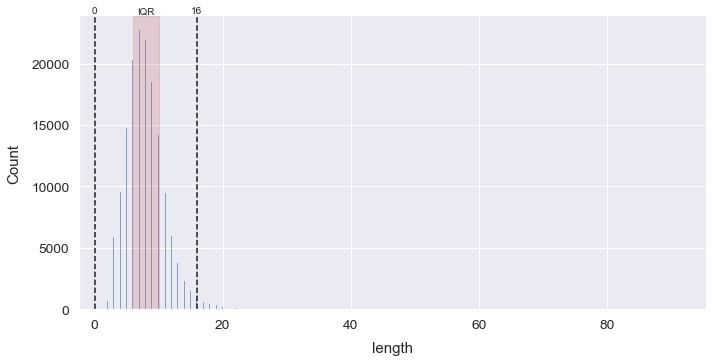

<IPython.core.display.Javascript object>

In [31]:
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["length"], g.axes[0, 0], num_format=".0f")

           n_trimmed  pct_trimmed
length         1,974            1
total_obs      1,974            1


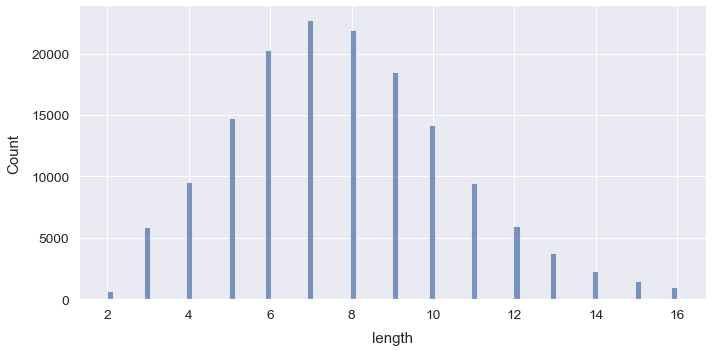

<IPython.core.display.Javascript object>

In [32]:
inlier_idx = outliers.tukey_trim(samp_vocab["length"]).index
samp_vocab = samp_vocab.loc[inlier_idx]
sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)

16 seems like a natural cutoff for word length, and it's what Tukey's IQR proximity rule dictates. I rewrite my token pattern to match sequences between two and 16 characters (inclusive).

In [33]:
def tokenize_2(docs, n_jobs=None):
    pattern = re.compile(r"(?i)\b[a-z_]{2,16}\b")
    return lang.process_strings(docs, pattern.findall, n_jobs=n_jobs)

<IPython.core.display.Javascript object>

In [34]:
samp_vocab.loc[samp_vocab.term.str.count("_") > 3]

term  freq  length  uniq_ratio
146581  scan_size_w_x_h     1      15    0.733333
95532   ____description     1      15    0.733333
129095   ____directions     1      14    0.714286
106881    warranty_____     1      13    0.538462
130677     ____ordering     1      12    0.666667
88702        __________     2      10    0.100000
118437        ____notes     1       9    0.666667
130395         dog____s     1       8    0.625000
95091            ______     1       6    0.166667
54142              ____     5       4    0.250000

<IPython.core.display.Javascript object>

I'm not interested in any of the underscores already in the data, only ones that I might add.

In [35]:
df["text"] = lang.strip_punct(df.loc[:, "text"], n_jobs=-1)
df["text"].str.contains("_").sum()

0

<IPython.core.display.Javascript object>

A related source of noise are strings with repetitive character (or word) sequences.

In [36]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=tokenize_2)
samp_vocab.sort_values("uniq_ratio").head(10)

term  freq  length  uniq_ratio
127775  wooooooooooooo     1      14    0.142857
83864     doodoodoodoo     2      12    0.166667
120375          cccccc     1       6    0.166667
94563            eeeee     1       5    0.200000
104133           rrrrr     1       5    0.200000
103502           xxxxx     1       5    0.200000
24870            aaaaa    26       5    0.200000
112906            cccc     1       4    0.250000
72629             mmmm     3       4    0.250000
150799    vzzzzzzzzzzt     1      12    0.250000

<IPython.core.display.Javascript object>

The above terms with repetitive sequences have low character uniqueness ratios, i.e. the ratio of character types to character tokens. That's how I'll filter them out.

Note: long multi-word amalgamations also have low character uniqueness simply because of their length, but I've already weeded those out.

<AxesSubplot:xlabel='uniq_ratio', ylabel='Count'>

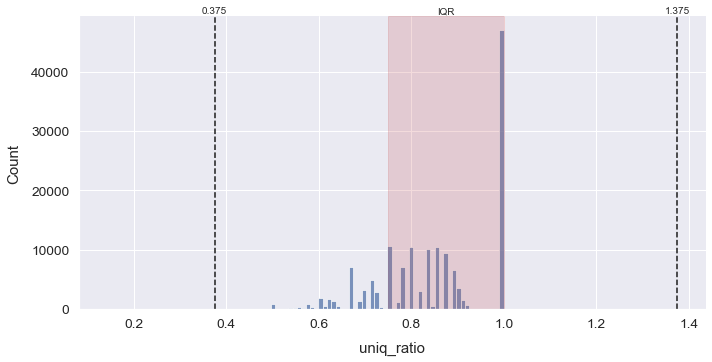

<IPython.core.display.Javascript object>

In [37]:
g = sns.displot(data=samp_vocab, x="uniq_ratio", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["uniq_ratio"], g.axes[0, 0], num_format=".3f")

The lower Tukey fence is located at 0.375. That seems like a reasonable cutoff.

In [38]:
steps = [
    tokenize_2,
    # functools.partial holds the argument 'thresh' in place
    partial(lang.uniq_char_thresh, thresh=0.375),
    " ".join,
]

df["text"] = lang.chain_processors(df.loc[:, "text"], steps, n_jobs=-1)

df["text"].head(10)

asin
B000050AUH    philips sonicare standard brush head sonic wav...
B000050B62    norelco deluxe reflex action cord cordless rec...
B000050B63    norelco quadra action cord cordless rechargeab...
B000050B64    norelco quadra action cord cordless rechargeab...
B000050B65    norelco deluxe quadra action cord cordless rec...
B000050B6B    philips norelco shaving heads replacement razo...
B000050B6H    philips norelco cool skin replacement heads fo...
B000050FDE    oral professional care power toothbrush the or...
B0000530JE    gillette sensorexcel cartridges pack of gillet...
B0000530S8    colgate baking soda peroxide whitening fluorid...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [39]:
samp_vocab.loc[samp_vocab.uniq_ratio > 0.375].sort_values("uniq_ratio").head(10)

term  freq  length  uniq_ratio
124901  sleeplessness     1      13    0.384615
147037  tetrastearate     1      13    0.384615
122993  totallytattoo     1      13    0.384615
145198  reengineering     1      13    0.384615
114008          deede     1       5    0.400000
48321           lilli     6       5    0.400000
95199      faaaassstt     1      10    0.400000
59598           ababa     4       5    0.400000
74657      elllleeott     2      10    0.400000
59377           wwiii     4       5    0.400000

<IPython.core.display.Javascript object>

Looks better. If I raise the threshold more, I'll begin to filter out too many normal words.

## Language

Next I run [langdetect](https://pypi.org/project/langdetect/) (a Google language detection algorithm) on the documents and select only the English product descriptions. I have nothing against the other languages, but there are not enough examples of them in the dataset to build a truly multilingual model. I don't want the model to associate Spanish words with 'amazon fashion', for example. That would generalize poorly.

This cell takes 30-40 minutes to run if `RUN_LANGDETECT` is set.

In [40]:
if RUN_LANGDETECT:
    # Wrapper of `langdetect.detect` with multiprocessing
    df["lang"] = lang.detect_lang(df.loc[:, "text"], seed=0, n_jobs=-1)
    df["lang"].to_json("data/langdetect.json")
else:
    df["lang"] = pd.read_json("data/langdetect.json", typ="series")
df["lang"].value_counts()

en    1089074
es       1016
it        214
fr        190
pt        134
nl        114
de        114
no        108
da         87
id         59
ca         46
sv         40
af         37
ro         24
so         24
pl         23
tl         17
sl         13
et         12
hr         12
cs         11
cy         10
sw          9
hu          6
tr          5
lt          5
sk          3
sq          3
vi          1
fi          1
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [41]:
df.lang.isna().sum()

0

<IPython.core.display.Javascript object>

In [42]:
df = df.drop(df.index[df.lang != "en"])
df["lang"].value_counts()

en    1089074
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

## Multi-word Expressions

For starters, I already have a lot of high quality brand phrases at my disposal. These are genuine multi-word expressions which should be understood as such by the model. Perhaps these will be too highly correlated with the one-hot-encoded brands, but I can easily remove one or the other from the feature matrix.

In [43]:
brand_ng = df.loc[:, "brand"].drop_duplicates().str.split("_").map(tuple)
brand_ng = brand_ng.loc[brand_ng.map(len) > 1]
brand_ng

asin
B000050AUH               (philips, sonicare)
B000050B6B                (philips, norelco)
B0000531WK                    (oreal, paris)
B0000532QF                  (tom, of, maine)
B000066SYD                     (aqua, fresh)
                           ...              
B00008YGO2                    (mumbo, jumbo)
B000ASBKGA                    (cta, digital)
B0017IK8W4                    (deep, silver)
B001K7HUUK           (alawar, entertainment)
B00GQVGV9Q    (big, leap, studios, pvt, ltd)
Name: brand, Length: 7364, dtype: object

<IPython.core.display.Javascript object>

I search for collocations in the text in a stratified fashion, scanning the documents of each 'main_cat' category as a separate corpus. The goal is to find ngrams which are peculiar to each category. I use pointwise mutual information (PMI) to identify bigrams.

In [45]:
cat_bg = lang.stratified_ngrams(
    df,
    n=2,
    text="text",
    # Stratify by 'main_cat'
    cat="main_cat",
    tokenizer=tokenize_2,
    metric="pmi",
    stopwords="nltk_english",
    # Select top scores in each category
    select_best=0.75,
    # Filter out ultra-rare ngrams
    min_freq=100,
    n_jobs=-1,
)
cat_bg

bigram     score     main_cat
0                (tom, maine)  9.641619   all beauty
1                (old, spice)  9.456347   all beauty
2               (pro, health)  9.002064   all beauty
3               (diamond, fx)  8.968957   all beauty
4         (philips, sonicare)  8.559704   all beauty
...                       ...       ...          ...
117504           (time, ever)  4.809147  video games
117505        (lets, players)  4.792794  video games
117506  (single, multiplayer)  4.784701  video games
117507           (pick, play)  4.760672  video games
117508        (xbox, console)  4.759459  video games

[117509 rows x 3 columns]

<IPython.core.display.Javascript object>

Next, I filter the bigrams so that there are no pairs which contain just one word type, e.g. ('same', 'same').

In [46]:
# def unique_filter(tuples):
#     size = np.array([len(x) for x in tuples])
#     n_unique = np.array([len(set(x)) for x in tuples])
#     return n_unique == size

<IPython.core.display.Javascript object>

In [47]:
# cat_bg = cat_bg.loc[unique_filter(cat_bg.bigram)]
# cat_bg.sort_values("score", ascending=False)

<IPython.core.display.Javascript object>

In [48]:
# Merge ngrams into single list
phrases = cat_bg.bigram.append(brand_ng).drop_duplicates().to_list()
display(len(phrases))
phrases[:10]

102029

[('tom', 'maine'),
 ('old', 'spice'),
 ('pro', 'health'),
 ('diamond', 'fx'),
 ('philips', 'sonicare'),
 ('face', 'paint'),
 ('brand', 'new'),
 ('verdana', 'helvetica'),
 ('arial', 'serif'),
 ('hisense', 'sero')]

<IPython.core.display.Javascript object>

In [49]:
ngram_tokenize = nltk.MWETokenizer(phrases).tokenize
ngram_tokenize

<bound method MWETokenizer.tokenize of <nltk.tokenize.mwe.MWETokenizer object at 0x0000025D285CD970>>

<IPython.core.display.Javascript object>

In [50]:
# Tokenize
df["text"] = tokenize_2(df.loc[:, "text"], n_jobs=-1)

# Switch to sequential processing for `ngram_tokenize` (faster)
df["text"] = df.loc[:, "text"].map(ngram_tokenize)

df["text"].head()

asin
B000050AUH    [philips_sonicare, standard, brush_head, sonic...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
Name: text, dtype: object

<IPython.core.display.Javascript object>

## Remove Stopwords

In [51]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

term   freq  length  uniq_ratio
0   the  73450       3         1.0
1   and  67141       3         1.0
2    to  39136       2         1.0
3    of  36462       2         1.0
4   for  27844       3         1.0
5  with  26135       4         1.0
6    in  25804       2         1.0
7    is  21190       2         1.0
8  your  14068       4         1.0
9  this  12626       4         1.0

<IPython.core.display.Javascript object>

In [52]:
# Fetch stopwords
stop = lang.fetch_stopwords("nltk_english")
# Run through tokenizer
stop = {y for x in stop for y in tokenize_2(x)}
# Make sure there are no brand terms
stop = stop.difference(df["brand"])
pprint(stop, compact=True)

{'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and',
 'any', 'are', 'aren', 'as', 'be', 'because', 'been', 'before', 'being',
 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'did', 'didn', 'do',
 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for',
 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having',
 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if',
 'in', 'into', 'is', 'isn', 'it', 'its', 'itself', 'just', 'll', 'ma', 'me',
 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'none',
 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our',
 'ours', 'ourselves', 'out', 'over', 'own', 're', 'same', 'shan', 'she',
 'should', 'shouldn', 'so', 'some', 'such', 'than', 'that', 'the', 'their',
 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this',
 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
 '

<IPython.core.display.Javascript object>

Next, I add stopwords which I've seen in a vision of the future.

In [108]:
stop.update(
    {
        "none",
        "span_class",
        "size_medium",
        "color_secondary",
        "shipping_weight",
        "weight_pounds",
        "shipping",
        "ounces_asin",
        "ounces",
        "asin",
        "item_model",
        "number_date",
        "model_number",
        "first_listed",
        "domestic_shipping",
        "currently_item",
        "shipped",
        "within",
        "apo_fpo",
        "addresses",
        "shipments_please",
        "manufacturer_regarding",
        "support_issues",
        "international_shipping",
        "eligible",
        "average_customer",
        "review",
        "review_fix",
        "udp_average",
        "customer_reviews",
        "small_extra",
        "hover_nounderline",
        "hover",
    }
)

NameError: name 'stop' is not defined

<IPython.core.display.Javascript object>

In [53]:
remove_stopwords = partial(lang.remove_stopwords, stopwords=stop)
df["text"] = df.loc[:, "text"].map(remove_stopwords)
df["text"]

asin
B000050AUH    [philips_sonicare, standard, brush_head, sonic...
B000050B62    [norelco, deluxe, reflex, action, cord, cordle...
B000050B63    [norelco, quadra, action, cord, cordless, rech...
B000050B64    [norelco, quadra, action, cord, cordless, rech...
B000050B65    [norelco, deluxe, quadra, action, cord, cordle...
                                    ...                        
B01HH6JEOC    [sims, kids_room, stuff, online, game, code, d...
B01HIU43S4    [games, sega, mega, drive, game_console, wired...
B01HIZF83S    [bioshock, collection, playstation, return, ci...
B01HJ149LI    [god, eater, resurrection, ps_vita, digital_co...
B01HJ14FDA    [jojo, eyes, heaven, complete, bundle, digital...
Name: text, Length: 1089074, dtype: object

<IPython.core.display.Javascript object>

In [54]:
samp_vocab = build_sample_vocab(df["text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

term  freq  length  uniq_ratio
0        at  4323       2       1.000
1      made  3494       4       1.000
2       use  2821       3       1.000
3  features  2782       8       0.875
4       one  2700       3       1.000
5    design  2255       6       1.000
6      easy  2239       4       1.000
7       set  2224       3       1.000
8      case  2220       4       1.000
9      inch  2030       4       1.000

<IPython.core.display.Javascript object>

In [55]:
df["text"] = df.loc[:, "text"].str.join(" ")
df["text"].head()

asin
B000050AUH    philips_sonicare standard brush_head sonic wav...
B000050B62    norelco deluxe reflex action cord cordless rec...
B000050B63    norelco quadra action cord cordless rechargeab...
B000050B64    norelco quadra action cord cordless rechargeab...
B000050B65    norelco deluxe quadra action cord cordless rec...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [56]:
if os.path.exists("data/model_data"):
    shutil.rmtree("data/model_data")

df.to_parquet(
    "data/model_data",
    engine="pyarrow",
    index=True,
    partition_cols="main_cat",
)

<IPython.core.display.Javascript object>


# Modeling
## Train-Test Split

In [24]:
df = pd.read_parquet("data/model_data", engine="pyarrow")
df.head()

text  \
asin                                                            
B000050AUH  philips_sonicare standard brush_head sonic wav...   
B000050B62  norelco deluxe reflex action cord cordless rec...   
B000050B63  norelco quadra action cord cordless rechargeab...   
B000050B64  norelco quadra action cord cordless rechargeab...   
B000050B65  norelco deluxe quadra action cord cordless rec...   

                                                        title  \
asin                                                            
B000050AUH               philips sonicare standard brush head   
B000050B62  norelco 5841xl deluxe reflex action cord/cordl...   
B000050B63  norelco 6826xl quadra action cord/cordless rec...   
B000050B64  norelco 6865xl quadra action cord/cordless rec...   
B000050B65  norelco 6885xl deluxe quadra action cord/cordl...   

                       brand lang    main_cat  
asin                                           
B000050AUH  philips_sonicare   en  all beauty  
B000050B62           norelco   en  all beauty  
B000050B63           norelco   en  all beauty  
B000050B64           norelco   en  all beauty  
B000050B65           norelco   en  all beauty

<IPython.core.display.Javascript object>

In [25]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((816805,), (272269,), (816805,), (272269,))

<IPython.core.display.Javascript object>

In [26]:
# X_trains, y_trains = utils.aligned_sample(
#     X_train, y_train, size=10000, weights=compute_sample_weight("balanced", y_train)
# )
# X_tests, y_tests = utils.aligned_sample(
#     X_test, y_test, size=5000, weights=compute_sample_weight("balanced", y_test)
# )

<IPython.core.display.Javascript object>

Next, I create the vectorizer. I have a taste for interpretability and transparency, which is why I've opted to use term-frequency vectorization (e.g. binary occurrence, raw term-frequency, or TF\*IDF). For the baseline model, I turn off IDF weighting and normalization. Therefore, `tf` is initially set to extract raw term-frequency vectors from the text.

In [27]:
tf = TfidfVectorizer(
    lowercase=False,
    token_pattern=r"(?i)\b[a-z_]{2,16}\b",
    norm=None,
    use_idf=False,
)

tf

TfidfVectorizer(lowercase=False, norm=None,
                token_pattern='(?i)\\b[a-z_]{2,16}\\b', use_idf=False)

<IPython.core.display.Javascript object>

I've opted to use Scikit-Learn's `SGDClassifier` because it's efficient on large datasets and works with several different loss functions. Essentially, it offers widely used linear classifiers with stochastic gradient descent optimization.

I could have also chosen a neural network classifier such as Scikit-Learn's ready-made multi-layer perceptron. However, neural networks take a long time to train and are the least interpretable algorithms on the market. For this project, given my limited computational resources and personal tastes, I've opted for a more traditional approach.

In [28]:
sgd = SGDClassifier(
    loss="hinge",
    class_weight="balanced",
    n_jobs=-1,
)

sgd

SGDClassifier(class_weight='balanced', n_jobs=-1)

<IPython.core.display.Javascript object>

The default loss function 'hinge' is a linear support vector classifier. `SGDClassifier` also offers squared hinge, logistic regression, modified Huber, and several losses designed for regression.

Next, I create a pipeline containing just two steps: the vectorizer and the classifier.

In [29]:
pipe = Pipeline(
    [
        ("vec", tf),
        ("cls", sgd),
    ],
    verbose=True,
)
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                 use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

The [User Guide](https://scikit-learn.org/stable/modules/sgd.html#sgd) emphasizes that `SGDClassifier` is sensitive to feature scale. However, since word frequencies are already on the same scale, there is no need to include a scaler.

A related concern is vector normalization (sample scale). The User Guide states that the default learning rate formula (`learning_rate='optimal'`) assumes "that the norm of the training samples is approx. 1." Another reason to normalize the vectors is to minimize the effect of document length. Again, I've turned it off for the baseline, but I fully expect to turn it back on later.

Next I define some functions which I'll use throughout the modeling process.

In [55]:
def plot_confusion_matrix(
    estimator,
    X_test=X_test,
    y_test=y_test,
    dst=None,
    xticks_rotation="vertical",
    **kwargs,
):
    """Plots confusion matrix with accuracy score."""
    ax = plotting.confusion_matrix(
        estimator,
        X_test,
        y_test,
        xticks_rotation=xticks_rotation,
        **kwargs,
    )
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    ax.set_title(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}", pad=5)
    if isinstance(dst, str):
        plt.savefig(dst)
    return ax

<IPython.core.display.Javascript object>

In [50]:
def get_report(estimator, X_test=X_test, y_test=y_test):
    """Returns standard classification metrics as a DataFrame."""
    report = classification_report(y_test, estimator.predict(X_test), output_dict=True)
    report = pd.DataFrame(report).T
    report.loc["accuracy", "support"] = report["support"].max()
    return report

<IPython.core.display.Javascript object>

In [53]:
def extract_coef(
    pipeline,
    classifier="cls",
    vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(pipeline[vectorizer].get_feature_names())
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

<IPython.core.display.Javascript object>

## Baseline SVM

Without further ado, it's time to fit the baseline model.

In [56]:
if "svm_1" in FIT_MODELS:
    # Train the model (slow)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_1.joblib", compress=True)

else:
    # Load the saved model (fast)
    pipe = joblib.load("models/svm_1.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b',
                                 use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

Since these models take a couple minutes to train, I always save them so they can be quickly reloaded.

In [34]:
len(pipe["vec"].get_feature_names())

490293

<IPython.core.display.Javascript object>

490K features is a lot, but not bad considering the size of the dataset. I'm sure it would've been much larger if not for my extensive preprocessing efforts.

<AxesSubplot:title={'center':'Accuracy: 0.96, Balanced Accuracy: 0.91'}, xlabel='Predicted label', ylabel='True label'>

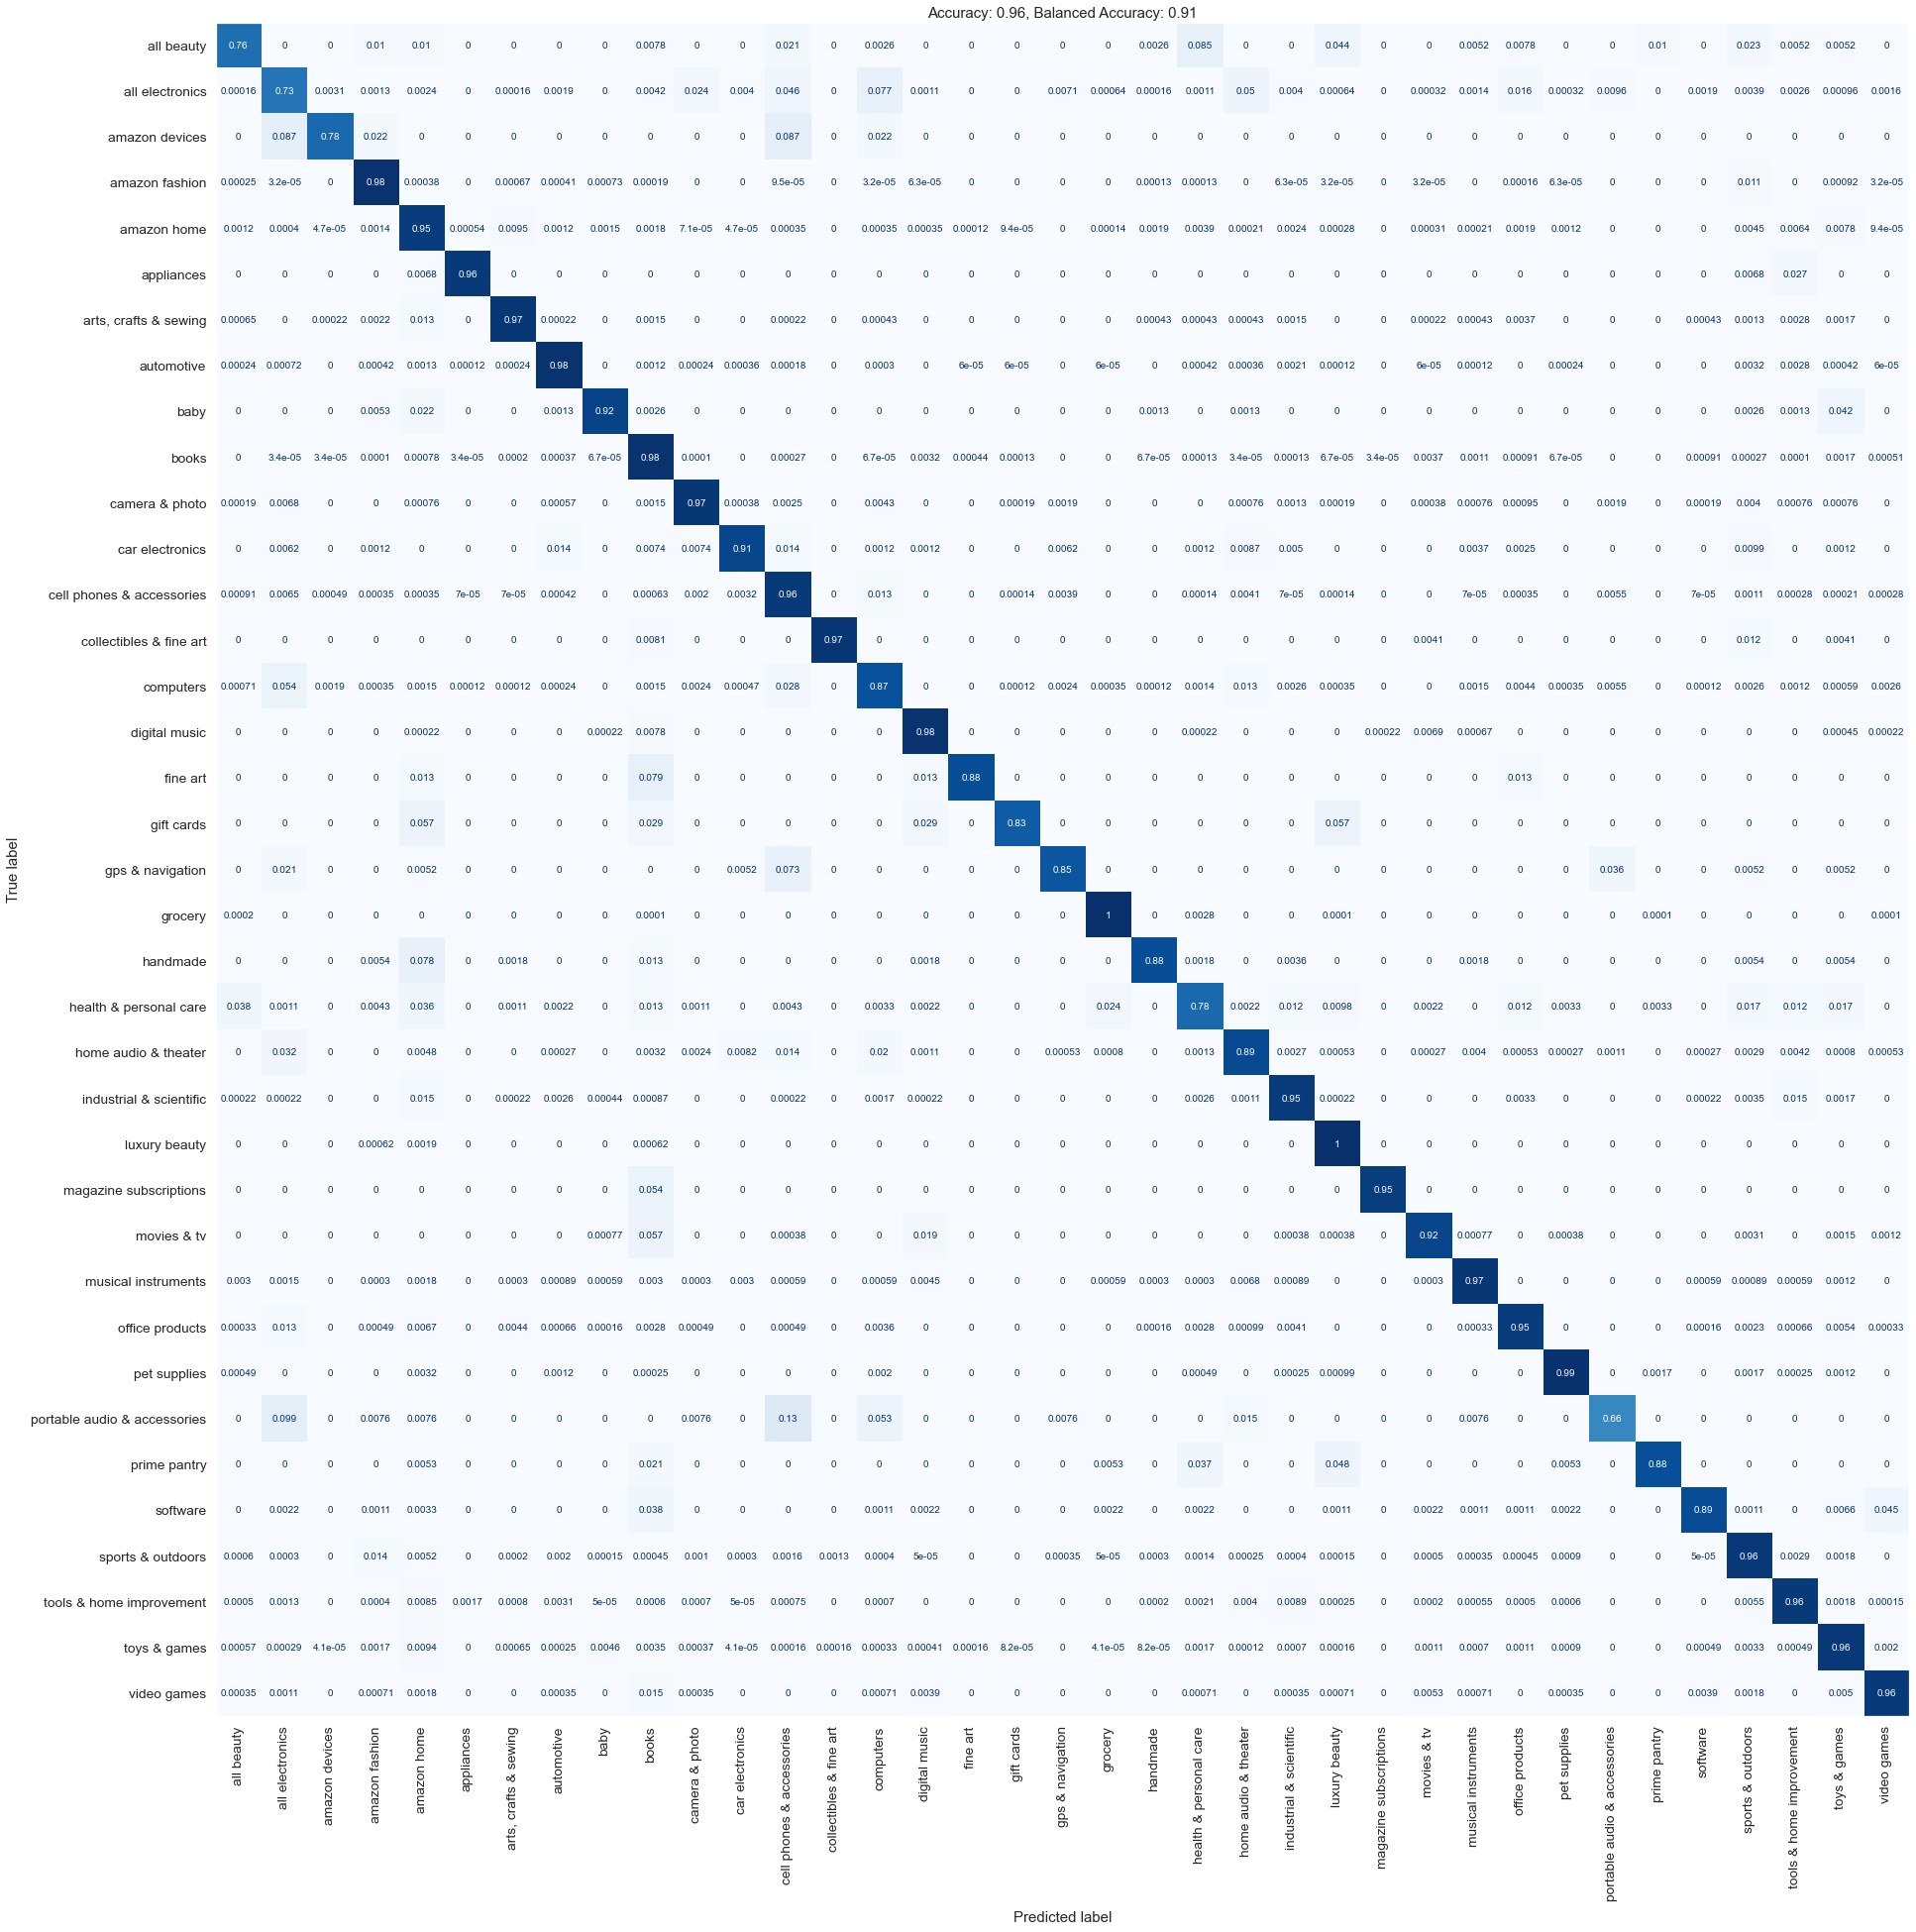

<IPython.core.display.Javascript object>

In [35]:
plot_confusion_matrix(pipe, dst="figures/svm_1_cm.svg")

Not bad for a baseline! Is it too good to be true, or have my painstaking efforts simply paid off? Let's look at the coefficients.

In [36]:
coef = extract_coef(pipe)
coef.sort_values("all electronics", ascending=False).head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
riorand         -0.046244         1.510175       -0.002040       -0.021422   
kenable          0.000000         1.068658       -0.003060       -0.004590   
amscope         -0.001360         1.048917       -0.004081       -0.006120   
javoedge        -0.002720         0.993226        0.298775        0.000000   
silverstone     -0.005441         0.985590        0.000000        0.001428   
thermaltake     -0.009521         0.924518        0.000000        0.000000   
ocz              0.000000         0.891810       -0.005101        0.000000   
antec           -0.057125         0.865585       -0.002040        0.000000   
pny             -0.006801         0.856527       -0.007141        0.000000   
altec_lansing    0.000000         0.852947       -0.016322        0.000000   

               amazon home  appliances  arts, crafts & sewing  automotive  \
riorand          -0.084577   -0.002448               0.000000   -0.032133   
kenable           0.000000    0.000000               0.000000   -0.012241   
amscope          -0.015580    0.000000              -0.006120   -0.012241   
javoedge         -0.013354    0.000000              -0.009181    0.000000   
silverstone      -0.011446    0.000000               0.058720   -0.009181   
thermaltake      -0.006677   -0.012241              -0.006120   -0.027046   
ocz              -0.003339   -0.007345              -0.004590   -0.038253   
antec            -0.005564    0.000000               0.000000   -0.006120   
pny               0.000000   -0.013465               0.000000   -0.003060   
altec_lansing     0.000000    0.000000               0.000000   -0.003060   

                  baby     books  ...  musical instruments  office products  \
riorand       -0.00306  0.000000  ...            -0.026012        -0.003060   
kenable        0.00000  0.000000  ...            -0.061205        -0.004590   
amscope        0.00000  0.000000  ...            -0.024482        -0.006120   
javoedge      -0.00306  0.000000  ...            -0.006120         0.000000   
silverstone    0.00000 -0.010881  ...            -0.027542         0.000000   
thermaltake    0.00000 -0.014961  ...            -0.004590        -0.026012   
ocz            0.00000  0.000000  ...            -0.009181         0.000000   
antec          0.00000  0.000000  ...            -0.061205         0.000000   
pny            0.00000  0.000000  ...            -0.003060        -0.032116   
altec_lansing -0.00459  0.000000  ...            -0.093337         0.000000   

               pet supplies  portable audio & accessories  prime pantry  \
riorand           -0.038471                     -0.009181     -0.004590   
kenable            0.000000                     -0.004591      0.000000   
amscope            0.000000                     -0.001530      0.000000   
javoedge          -0.031476                     -0.108647      0.000000   
silverstone        0.000000                      0.000000      0.000000   
thermaltake        0.000000                     -0.006121      0.000000   
ocz                0.000000                     -0.003060      0.000000   
antec              0.000000                     -0.006886     -0.010711   
pny                0.000000                     -0.001530      0.000000   
altec_lansing      0.000000                      0.000000      0.000000   

               software  sports & outdoors  tools & home improvement  \
riorand       -0.006120          -0.026931                 -0.107450   
kenable        0.000000           0.000000                 -0.024482   
amscope       -0.015301          -0.050189                 -0.032643   
javoedge       0.000000           0.000000                  0.000000   
silverstone    0.000000          -0.001224                 -0.005441   
thermaltake    0.000000          -0.024483                 -0.050325   
ocz           -0.004590          -0.013465                  0.000000   
antec          0.000000          -0.

<IPython.core.display.Javascript object>

The coefficients look just as I expected. Brand terms are at the top, at least for 'all electronics'. While I did filter out only the top 1% of brands for each category, there are still nearly 10,000 brands in the dataset. Moreover, these brand names are recognizable and make sense.

Next, it's time to choose the loss function.

## SGD Classifier Selection

I try out all four of the classification loss functions: 'hinge', 'squared_hinge', 'log', and 'modified_huber'. I also tune the penalty and regularization strength, as well as the basic vectorizer settings.

In [37]:
sgd_grid = {
    "cls__loss": ["hinge", "squared_hinge", "log", "modified_huber"],
    "cls__penalty": ["l1", "l2"],
    "cls__alpha": sp.stats.loguniform(1e-8, 1.0),
    "vec__use_idf": [True, False],
    "vec__binary": [True, False],
    "vec__norm": ["l1", "l2", None],
}

sgd_grid

{'cls__loss': ['hinge', 'squared_hinge', 'log', 'modified_huber'],
 'cls__penalty': ['l1', 'l2'],
 'cls__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c7338cb040>,
 'vec__use_idf': [True, False],
 'vec__binary': [True, False],
 'vec__norm': ['l1', 'l2', None]}

<IPython.core.display.Javascript object>

Given the size of the dataset, with `X_train` at over 800K samples, I opt for a randomized search with successive halving. It's essentially a survival-of-the-fittest contest between a set of randomly-selected parameter combinations. In the first round, the parameters are tested on 10K samples. With each successive round, the weak combinations are eliminated and the amount of data increases.

It's a more scalable approach than running an exhaustive search on the full `X_train`, though it still takes an hour or two. Note that I am optimizing **accuracy** while keeping an eye on "balanced accuracy" a.k.a. macro average (unweighted) recall. I'm mostly concerned with the overall ratio of correct classification, as long as the small classes are reasonably accommodated.

In [57]:
if "loss" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        sgd_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/loss_cv.joblib",
        kind="hrand",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    loss_results = gs.cv_results_
else:
    loss_results = joblib.load("sweeps/loss_cv.joblib")

loss_results = selection.prune_cv(loss_results)
loss_results.head(10)

alpha   loss penalty  binary norm  use_idf  \
0  5.255038e-07  hinge      l2    True   l2     True   
1  5.255038e-07  hinge      l2    True   l2     True   
2  7.157636e-07    log      l2   False   l2     True   
3  1.605315e-08    log      l2   False   l1     True   
4  7.157636e-07    log      l2   False   l2     True   
5  5.255038e-07  hinge      l2    True   l2     True   
6  1.605315e-08    log      l2   False   l1     True   
7  3.082426e-06  hinge      l2   False   l2    False   
8  7.857063e-06  hinge      l2   False   l2    False   
9  4.430582e-08    log      l2    True   l1     True   

                                              params  mean_fit_time  \
0  {'cls__alpha': 5.25503769545935e-07, 'cls__los...     241.589407   
1  {'cls__alpha': 5.25503769545935e-07, 'cls__los...     121.395599   
2  {'cls__alpha': 7.15763577656479e-07, 'cls__los...     102.892204   
3  {'cls__alpha': 1.6053147327650663e-08, 'cls__l...      99.634805   
4  {'cls__alpha': 7.15763577656479e-07, 'cls__los...      26.191196   
5  {'cls__alpha': 5.25503769545935e-07, 'cls__los...      26.031597   
6  {'cls__alpha': 1.6053147327650663e-08, 'cls__l...      28.755394   
7  {'cls__alpha': 3.0824261182174037e-06, 'cls__l...      24.616992   
8  {'cls__alpha': 7.857063428799315e-06, 'cls__lo...      23.931392   
9  {'cls__alpha': 4.4305817166390654e-08, 'cls__l...      27.540397   

   mean_score  rank_score  
0    0.963798           1  
1    0.953789           2  
2    0.949059           3  
3    0.947215           4  
4    0.935344           5  
5    0.933922           6  
6    0.933267           7  
7    0.928700           8  
8    0.924689           9  
9    0.924622          10

<IPython.core.display.Javascript object>

The default hinge loss wins, with logistic regression in a close second. L2 penalty looks to have completely dominated L1, and the top-scoring 'alpha' values are on the order of $10^7$ or $10^8$. Unsurprisingly, the vector normalization was selected (L2) and IDF weighting to reduce the impact of common terms. Binary occurrence was selected over term-frequency, which I wouldn't have predicted.

For each document and each term, the vectorizer will mark whether the term occurs in that document. Then the vectorizer will apply IDF (inverse document frequency) weighting to the binary features, placing weight on rare terms and withholding it from common ones. Then, finally, it will normalize the vectors to reduce the effect of document length (longer documents typically have a wider variety of terms, meaning more 1s in their vectors).

## Fit Linear SVM

The next step is to set the new parameters and fit the second version of the model.

In [60]:
loss_params = loss_results.loc[0, "params"]
display(loss_params)
pipe.set_params(**loss_params)

{'cls__alpha': 5.25503769545935e-07,
 'cls__loss': 'hinge',
 'cls__penalty': 'l2',
 'vec__binary': True,
 'vec__norm': 'l2',
 'vec__use_idf': True}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [61]:
if "svm_2" in FIT_MODELS:
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_2.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_2.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.97, Balanced Accuracy: 0.92'}, xlabel='Predicted label', ylabel='True label'>

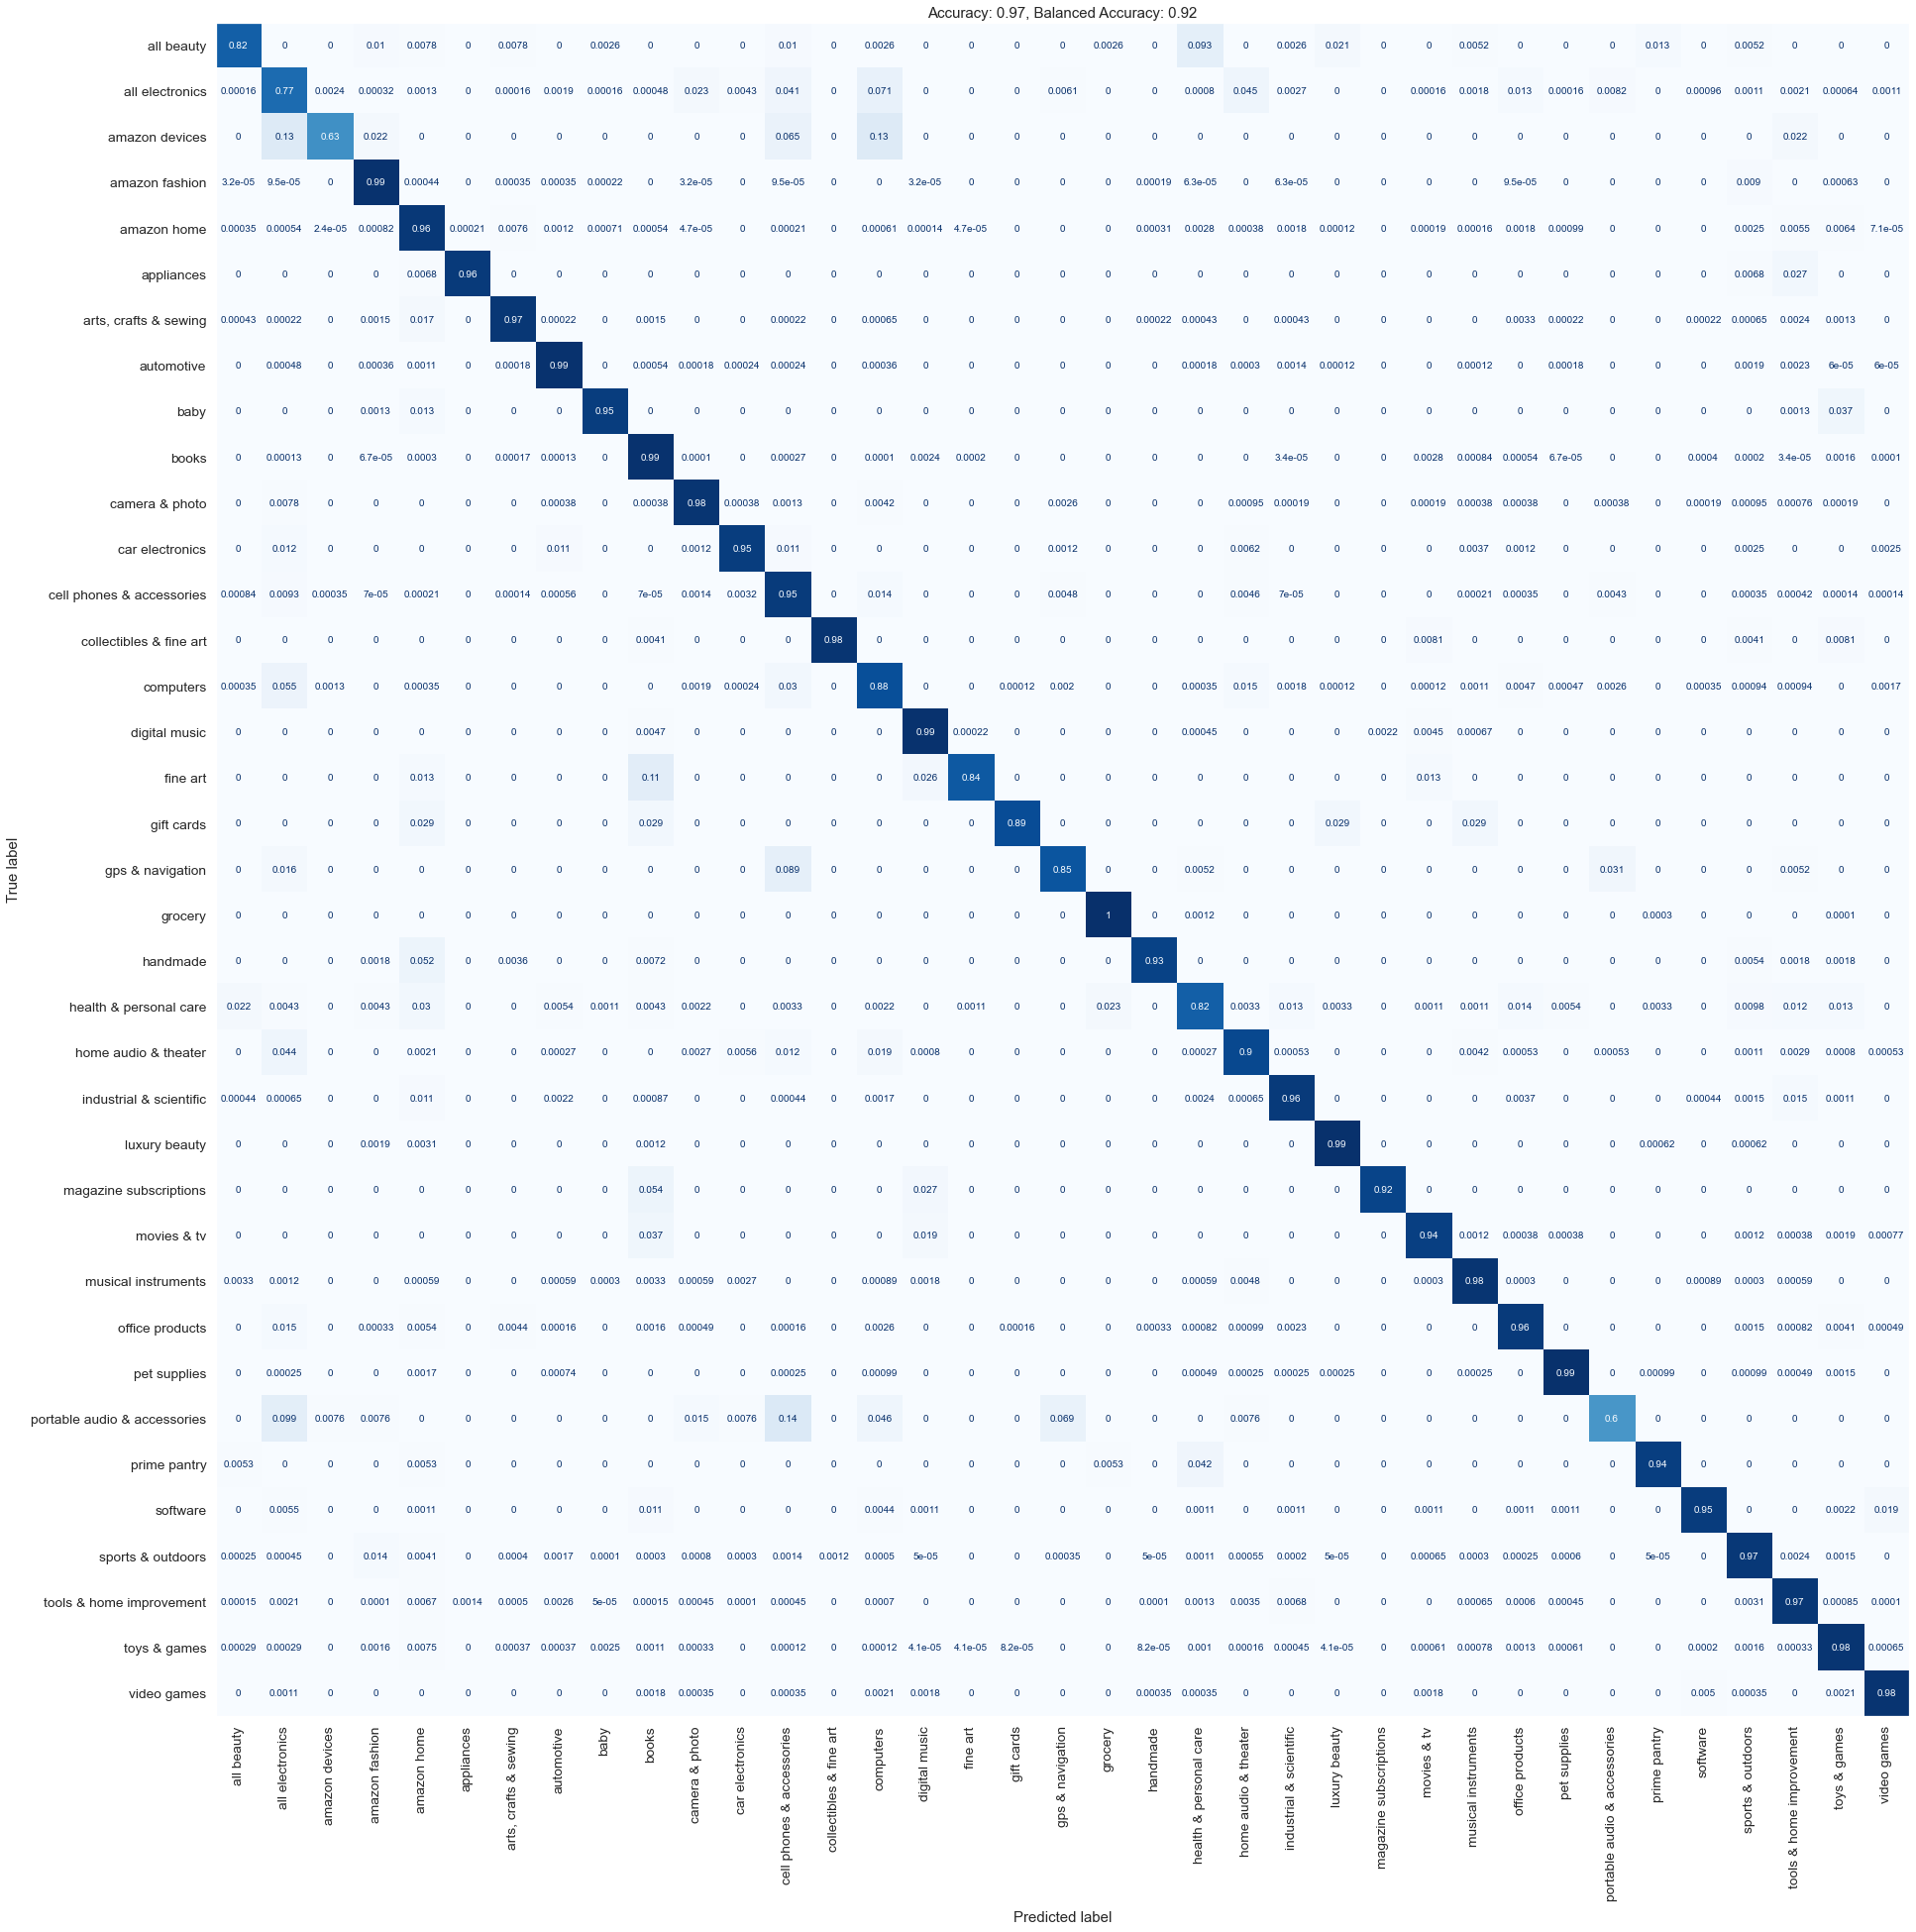

<IPython.core.display.Javascript object>

In [62]:
plot_confusion_matrix(pipe, dst="figures/svm_2_cm.svg")

The accuracy is now up to 0.97, which is about the best one could hope for. The balanced accuracy (which gives all classes equal weight) is up to 0.93, which is also pretty good.

It looks like 'amazon devices' and 'portable audio & accessories' have the lowest recall. Amazon doesn't need this classifier for it's own proprietary devices, but 'portable audio' could be better. It's confused with 'cell phones & accessories' about 14% of the time.

Anyway, my focus is on overall accuracy, and I'm not interested in boosting the recall of small classes at the expense of large ones.

In [64]:
coef = extract_coef(pipe)
coef.sort_values("video games", ascending=False).head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
cta_digital       -0.054030        -1.991785       -0.075144       -0.125338   
electronic_arts   -0.123203        -0.858045        0.000000       -0.217288   
activision         0.000000        -0.523384       -0.018551       -0.198718   
mad_catz           0.000000        -1.497890       -0.038329        0.000000   
ubisoft           -0.038466        -0.687798        0.000000       -0.038747   
sega              -0.090484        -0.268420        0.000000       -0.085997   
atari              0.000000        -0.526296        0.000000       -0.046279   
nintendo          -0.541403        -1.125664       -1.111925       -0.237738   
thq               -0.155425        -0.055496       -0.029042       -0.054598   
download          -0.254752        -0.158222       -7.882078       -0.331084   

                 amazon home  appliances  arts, crafts & sewing  automotive  \
cta_digital        -0.744291    0.000000               0.000000   -0.470289   
electronic_arts    -0.663969    0.000000               0.000000   -0.572850   
activision         -0.104896    0.000000               0.000000   -0.161371   
mad_catz           -0.406250    0.000000               0.000000   -0.162561   
ubisoft            -0.369068   -0.023823               0.000000   -0.334791   
sega               -0.094998    0.000000              -0.113598   -0.054244   
atari              -0.130502    0.000000              -0.059866   -0.151310   
nintendo           -0.311833    0.000000              -0.144814   -0.360115   
thq                 0.000000    0.000000               0.000000   -0.210214   
download           -1.031313    1.922576              -0.484296   -0.164164   

                     baby     books  ...  musical instruments  \
cta_digital      0.000000  0.000000  ...            -0.239398   
electronic_arts  0.000000 -2.067477  ...             0.000000   
activision       0.000000 -2.196023  ...            -0.393188   
mad_catz         0.000000 -0.050244  ...            -1.748081   
ubisoft         -0.076625 -2.351333  ...            -0.268656   
sega             0.000000 -1.817123  ...            -0.084120   
atari           -0.052222 -1.760375  ...            -0.140078   
nintendo        -0.077148 -1.061734  ...            -0.692412   
thq              0.000000 -1.536925  ...            -0.284466   
download        -0.339896 -3.342564  ...            -0.435266   

                 office products  pet supplies  portable audio & accessories  \
cta_digital            -0.396788     -0.420094                     -0.123438   
electronic_arts        -0.128432     -0.614420                     -0.019526   
activision              0.000000     -0.369082                     -0.022677   
mad_catz               -0.059959      0.000000                     -0.126272   
ubisoft                -0.171741     -0.284148                      0.000000   
sega                   -0.162630      0.020350                     -0.017591   
atari                   0.000000      0.000000                      0.000000   
nintendo               -0.552112     -0.530597                     -0.291533   
thq                    -0.031116     -0.701789                      0.000000   
download                0.092466     -0.121791                     -0.331944   

                 prime pantry  software  sports & outdoors  \
cta_digital          0.000000  0.000000          -1.964130   
electronic_arts      0.000000 -2.896326          -1.745522   
activision           0.000000 -2.901789          -2.491137   
mad_catz             0.000000 -0.170692          -1.621045   
ubisoft              0.000000 -2.450876          -0.774797   
sega                -0.052241 -0.904053          -1.085918   
atari                0.000000 -2.924461          -1.117478   
nintendo            -0.075895 -1.606198          -1.759800   
thq                  0.000000 -1.150869          -0.569325   
download            -0.065557  0.317448          

<IPython.core.display.Javascript object>

Another successful coefficient sanity check. Nearly all of the top features for video games are recognizable brand names.

## Optimize Learning Rate

Next I'll optimize the learning rate for stochastic gradient descent. The default is 'optimal', which is a function of $\alpha$, the current time step $t$, and a heuristic value $t_0$.

The other options I'll try are 'constant' and 'adaptive'. As the name suggests, 'constant' is just the constant $eta_0$, which is passed as a hyperparameter. For 'adaptive', the initial learning rate is $eta_0$, but when the stopping criterion is reached, the learning rate is divided by 5 and the descent continues (defying the gods). The descent doesn't stop until the learning rate goes below $10^{-6}$.

In [65]:
learn_grid = [
    {
        "learning_rate": ["constant", "adaptive"],
        "eta0": sp.stats.loguniform(1e-4, 1e4),
        "average": [True, False],
    },
    {
        "learning_rate": ["optimal"],
        "average": [True, False],
    },
]
learn_grid

[{'learning_rate': ['constant', 'adaptive'],
  'eta0': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c7a46fe5b0>,
  'average': [True, False]},
 {'learning_rate': ['optimal'], 'average': [True, False]}]

<IPython.core.display.Javascript object>

In [66]:
if "learn" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        learn_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/learn_cv.joblib",
        kind="hrand",
        add_prefix="cls__",
        min_resources=10 ** 4,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    learn_results = gs.cv_results_
else:
    learn_results = joblib.load("sweeps/learn_cv.joblib")

learn_results = selection.prune_cv(learn_results)
learn_results.head(10)

average      eta0 learning_rate  \
0     True  0.841666      adaptive   
1     True  0.841666      adaptive   
2    False  1.656650      adaptive   
3    False  0.857235      constant   
4     True  0.841666      adaptive   
5    False  1.656650      adaptive   
6    False  0.857235      constant   
7    False  1.925135      adaptive   
8    False  0.086955      constant   
9    False  0.081826      constant   

                                              params  mean_fit_time  \
0  {'cls__average': True, 'cls__eta0': 0.84166636...    2718.412539   
1  {'cls__average': True, 'cls__eta0': 0.84166636...     971.841199   
2  {'cls__average': False, 'cls__eta0': 1.6566501...     362.309605   
3  {'cls__average': False, 'cls__eta0': 0.8572352...      85.645006   
4  {'cls__average': True, 'cls__eta0': 0.84166636...     289.311396   
5  {'cls__average': False, 'cls__eta0': 1.6566501...     117.517600   
6  {'cls__average': False, 'cls__eta0': 0.8572352...      36.053796   
7  {'cls__average': False, 'cls__eta0': 1.9251349...     116.465399   
8  {'cls__average': False, 'cls__eta0': 0.0869545...      26.184200   
9  {'cls__average': False, 'cls__eta0': 0.0818255...      87.510197   

   mean_score  rank_score  
0    0.964341           1  
1    0.954659           2  
2    0.954233           3  
3    0.952689           4  
4    0.938111           5  
5    0.937444           6  
6    0.937389           7  
7    0.936867           8  
8    0.935878           9  
9    0.935878           9

<IPython.core.display.Javascript object>

Looks like 'adaptive' wins, and with an epic fit time. The long fit time makes sense given the unyielding nature of the algorithm.

## Fit Final Model

Time to fit the third and final version of the model, now with 'adaptive' learning rate.

In [68]:
learn_params = learn_results.loc[0, "params"]
display(learn_params)
pipe.set_params(**learn_params)

{'cls__average': True,
 'cls__eta0': 0.8416663608926325,
 'cls__learning_rate': 'adaptive'}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [70]:
if "svm_3" in FIT_MODELS:
    pipe.fit(X_train, y_train)

    joblib.dump(pipe, "models/svm_3.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_3.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='(?i)\\b[a-z_]{2,16}\\b')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

That took ~10 minutes to train, which is about 5x a long as the 'optimal' learning rate.

<AxesSubplot:title={'center':'Accuracy: 0.97, Balanced Accuracy: 0.93'}, xlabel='Predicted label', ylabel='True label'>

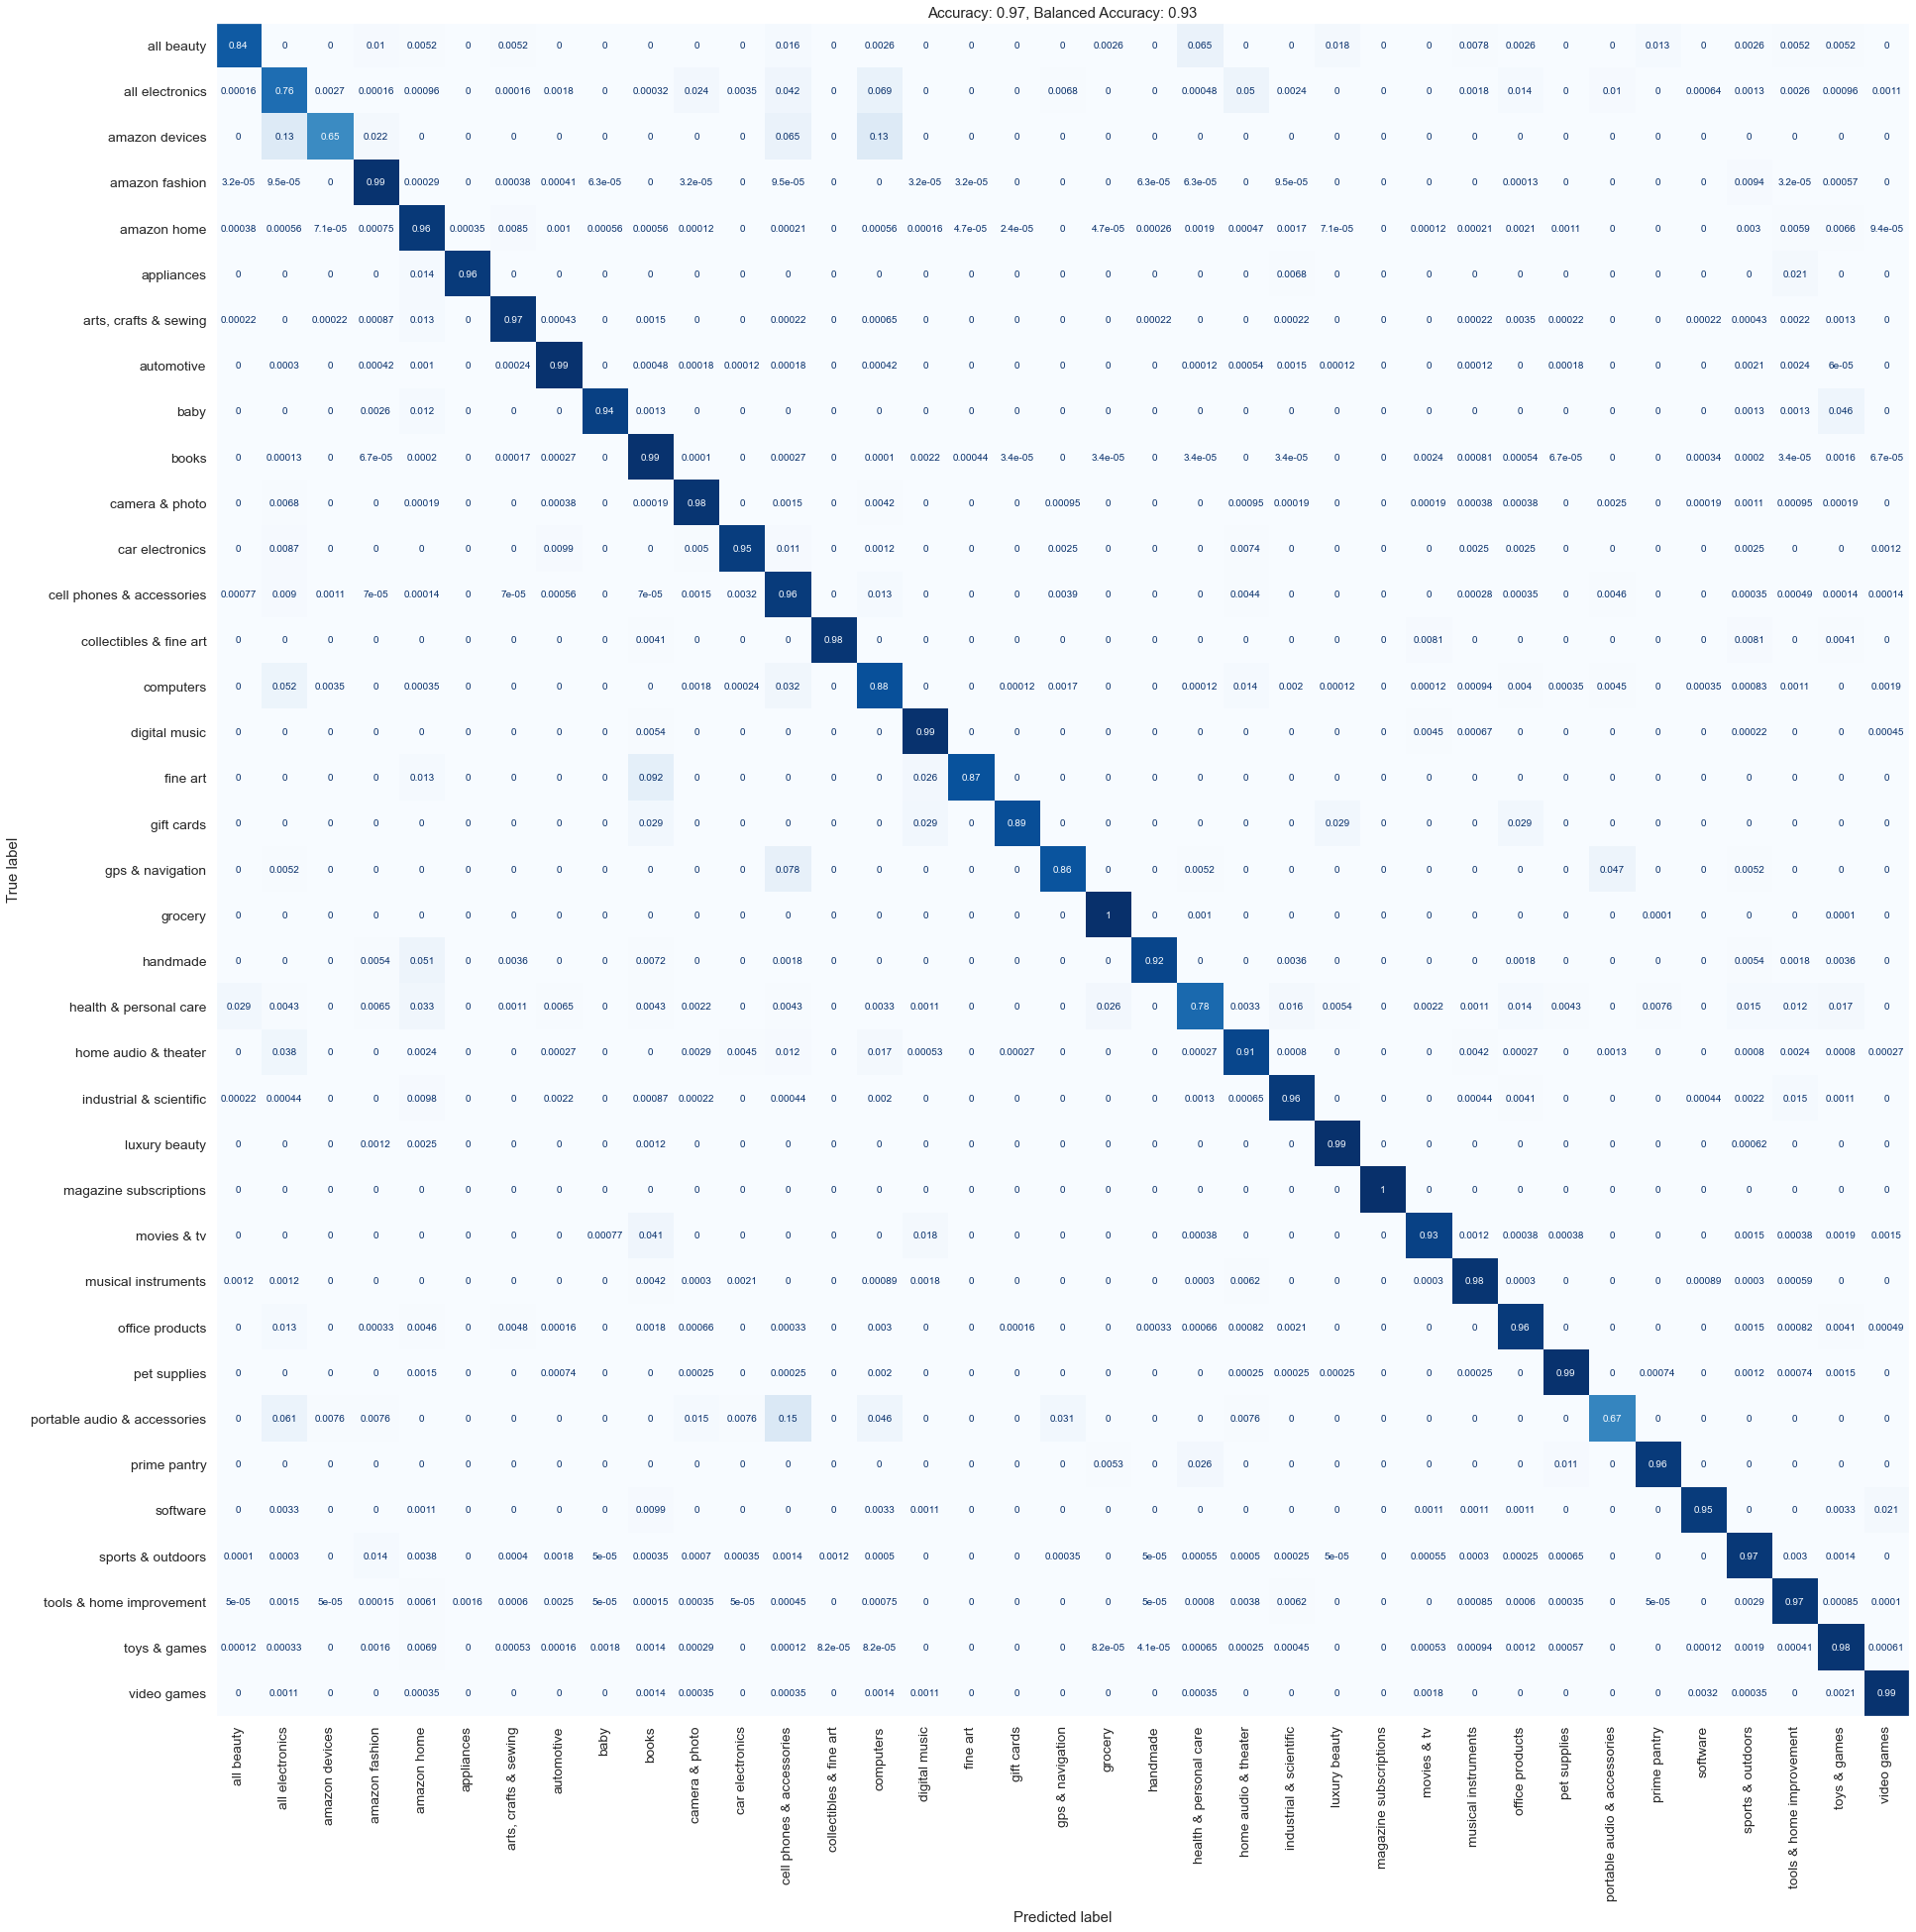

<IPython.core.display.Javascript object>

In [71]:
plot_confusion_matrix(pipe, dst="figures/svm_3_cm.svg")

It's still sitting at 0.97 accuracy, but the balanced accuracy improved slightly. 0.97 accuracy is already quite a satisfactory number, and it's hard to imagine I could do better by fiddling with the hyperparameters.

# Interpretation

The next step is to take a closer look at the final model's coefficients.

In [72]:
coef = extract_coef(pipe)
coef.sort_values("amazon fashion", ascending=False).head(10)

all beauty  all electronics  amazon devices  amazon fashion  \
shipping_weight   -2.203891        -0.269793       -0.410368        8.887854   
inches_shipping   -1.987808        -1.207055       -0.372282        7.405772   
peach_couture     -0.509489        -0.065700       -0.225991        6.417707   
sk_hat_shop       -0.662571        -0.021405       -0.078427        5.011318   
clothing_shoes    -0.702102        -0.321396       -0.006489        4.921858   
port_authority    -0.017835         0.030074       -0.055572        4.745990   
weight_pounds     -0.568501         0.882933       -0.023355        4.349349   
fun_world         -0.085025         0.000000        0.000000        4.094485   
elope             -0.100848         0.000000        0.000000        4.033908   
casio             -0.153590         3.101117       -0.069090        3.977470   

                 amazon home  appliances  arts, crafts & sewing  automotive  \
shipping_weight    -3.783184   -0.588516              -1.822334   -1.448226   
inches_shipping    -4.463083    0.883503              -2.161125   -1.659545   
peach_couture      -2.163820    0.000000              -0.358708   -0.102838   
sk_hat_shop        -0.197471    0.000000              -0.106013   -0.123603   
clothing_shoes     -1.125745    0.000000              -0.958543   -0.123053   
port_authority     -0.120332    0.000000              -0.076774    0.000000   
weight_pounds      -1.910364    1.025725              -0.329422   -0.770970   
fun_world          -0.616151    0.000000              -0.017685    0.000000   
elope              -0.467045    0.000000              -0.042416    0.000000   
casio              -0.840237   -0.088109              -0.029176   -0.241068   

                     baby     books  ...  musical instruments  \
shipping_weight -1.499415 -1.469967  ...            -0.103974   
inches_shipping -1.977523 -1.682043  ...            -0.440319   
peach_couture   -0.163783 -0.098774  ...            -0.051050   
sk_hat_shop     -0.104573 -0.094292  ...             0.000000   
clothing_shoes  -0.553491 -0.514972  ...             0.000000   
port_authority  -0.019104 -0.094971  ...             0.000000   
weight_pounds   -1.239391 -0.780733  ...            -0.335235   
fun_world       -0.277929  0.000000  ...            -0.418879   
elope           -0.065130 -0.142182  ...             0.000000   
casio           -0.141133 -0.962351  ...             2.759939   

                 office products  pet supplies  portable audio & accessories  \
shipping_weight        -0.277898     -0.676173                     -0.331140   
inches_shipping        -1.157677     -0.664986                     -0.326980   
peach_couture          -0.015245     -0.422591                      0.000000   
sk_hat_shop            -0.251850     -0.016235                      0.000000   
clothing_shoes          0.276911      0.000000                      0.000000   
port_authority         -0.026823     -0.015785                     -0.012696   
weight_pounds          -0.624776     -0.154004                     -0.427886   
fun_world               0.000000     -0.311876                      0.000000   
elope                  -0.084206     -0.096876                      0.000000   
casio                  -0.196619      0.000000                     -0.777921   

                 prime pantry  software  sports & outdoors  \
shipping_weight     -0.207064 -0.171099          -6.714227   
inches_shipping     -0.414101 -0.372650          -6.000702   
peach_couture        0.000000 -0.153522          -3.127192   
sk_hat_shop          0.000000  0.000000          -3.194218   
clothing_shoes       0.000000 -0.081071          -3.171420   
port_authority       0.000000  0.000000          -3.808726   
weight_pounds       -0.236423 -0.355351          -2.342695   
fun_world           -0.009606  0.000000          -0.135931   
elope                0.000000  0.000000          -0.649864   
casio                0.000000 -0.370268          

<IPython.core.display.Javascript object>

Interestingly enough, the top coefficients for 'amazon fashion' include both brands and shipping-related terms. I wonder why those terms show up at the top for fashion and not other categories.

In [82]:
cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
np.random.shuffle(cmaps)
cmaps

['YlGn',
 'PuBuGn',
 'BuGn',
 'RdPu',
 'Purples',
 'GnBu',
 'YlOrBr',
 'PuRd',
 'Blues',
 'BuPu',
 'Greens',
 'YlOrRd',
 'OrRd',
 'PuBu',
 'Oranges',
 'YlGnBu',
 'Reds']

<IPython.core.display.Javascript object>

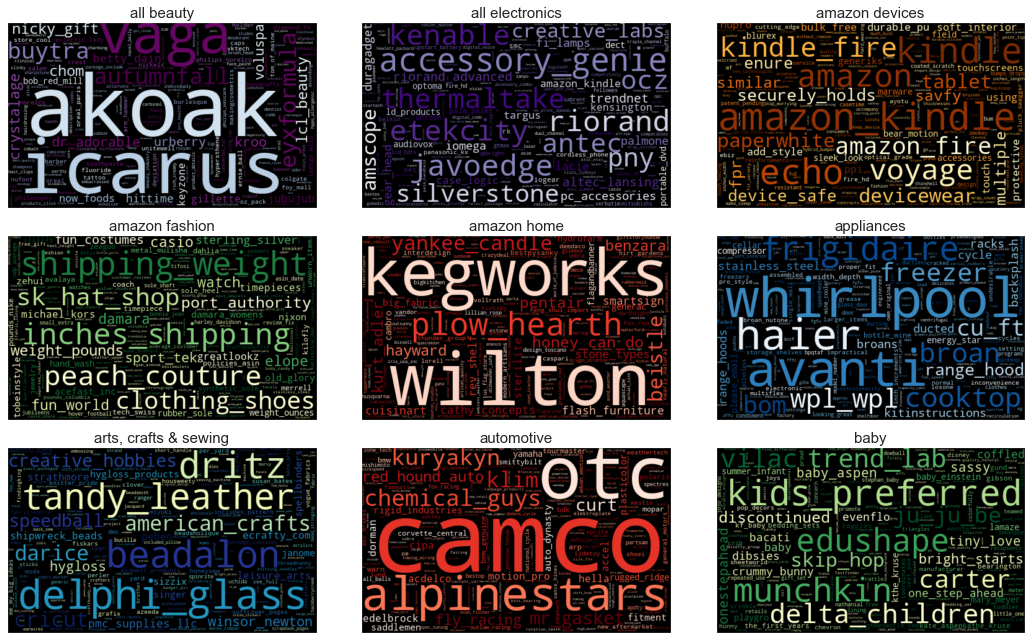

<IPython.core.display.Javascript object>

In [86]:
fig = plotting.wordcloud(coef.iloc[:, :9], cmap=np.random.choice(cmaps, 9).tolist(),)

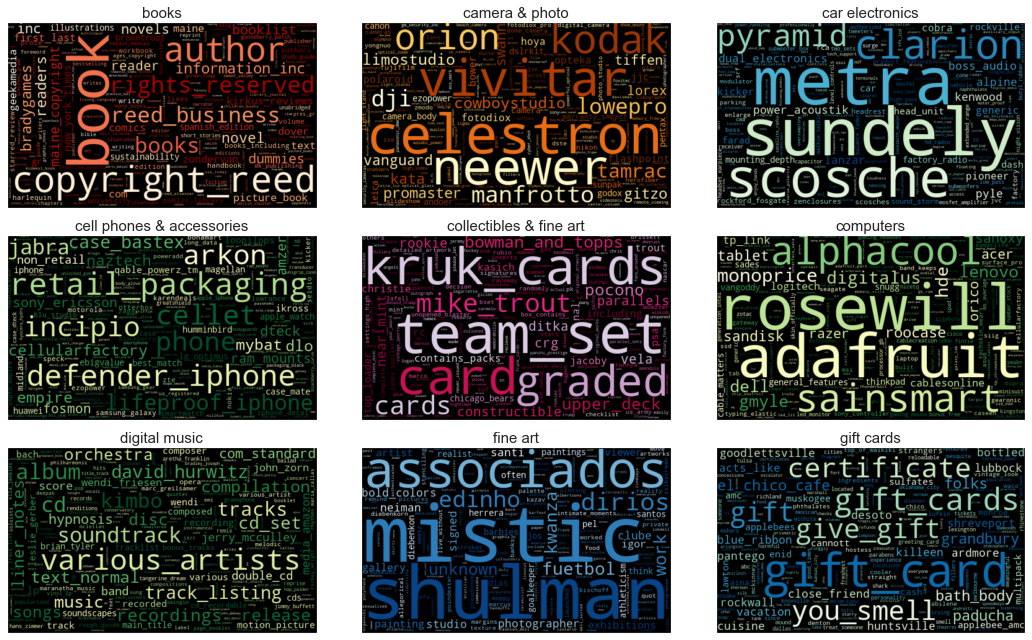

<IPython.core.display.Javascript object>

In [87]:
fig = plotting.wordcloud(
    coef.iloc[:, 9:18],
    cmap=np.random.choice(cmaps, 9).tolist(),
)

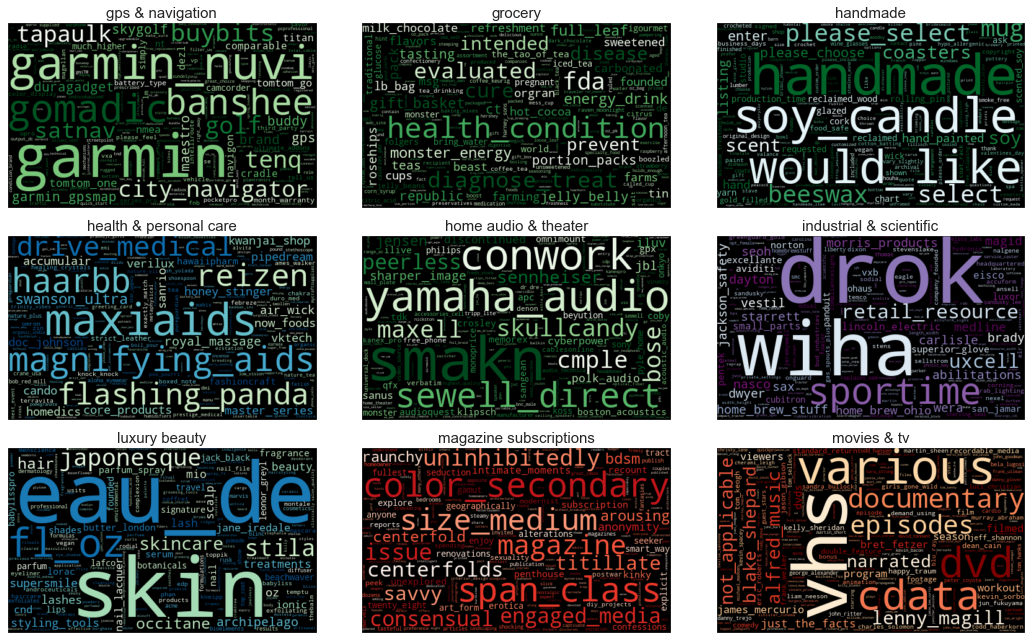

<IPython.core.display.Javascript object>

In [88]:
fig = plotting.wordcloud(
    coef.iloc[:, 18:27],
    cmap=np.random.choice(cmaps, 9).tolist(),
)

In [106]:
df.query("main_cat=='amazon fashion'").loc[df.text.str.contains("shipping")].text.iloc[
    0
]

'timex_men metal tech sports dress analog watch water_resistant indiglo illumination adjustable stainless_steel silver_metal bracelet timex_group one best_known american watch_companies timex_headquarters located middlebury_connecticut substantial_operations china philippines india full_scale sales_companies canada uk_france mexico company_began waterbury_clock connecticut_naugatuck valley_known nineteenth_century switzerland america_sister company_waterbury watch manufactured first_inexpensive mechanical_pocket watch world_war waterbury_began making_wristwatches become_popular made_history creating first_mickey mouse_clock license walt_disney mickey_hands pointing time world_war ii_waterbury renamed time company company_introduced wristwatch_called timex next_three decades_timex sold series advertisements emphasized durability putting watch torture_tests falling grand_coulee dam strapped propeller outboard_motor slogan takes_licking keeps ticking help former_olympic broadcaster_spokes

<IPython.core.display.Javascript object>

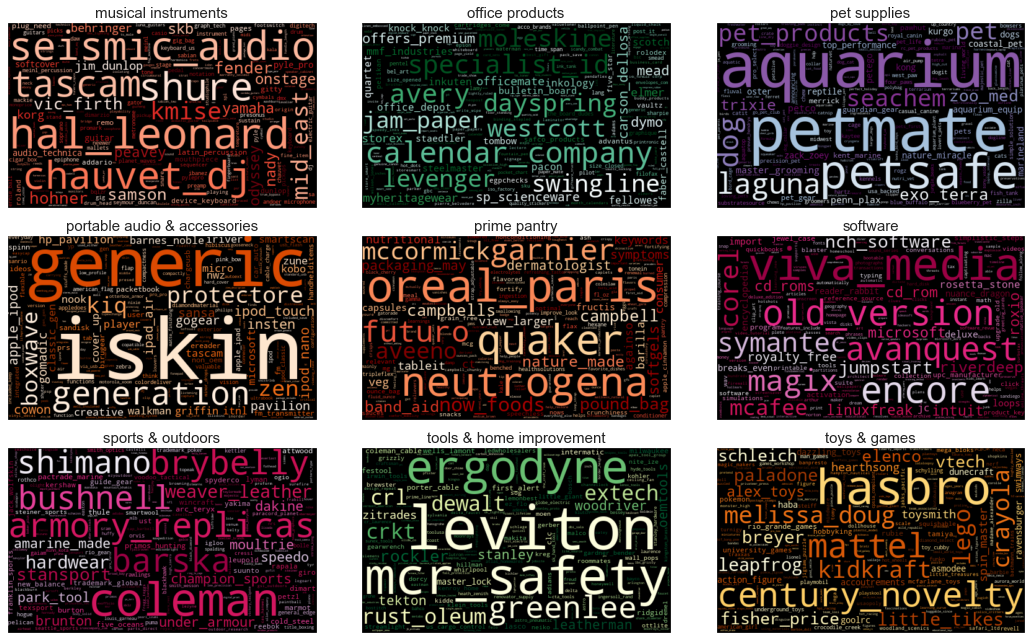

<IPython.core.display.Javascript object>

In [89]:
fig = plotting.wordcloud(
    coef.iloc[:, 27:36],
    cmap=np.random.choice(cmaps, 9).tolist(),
)

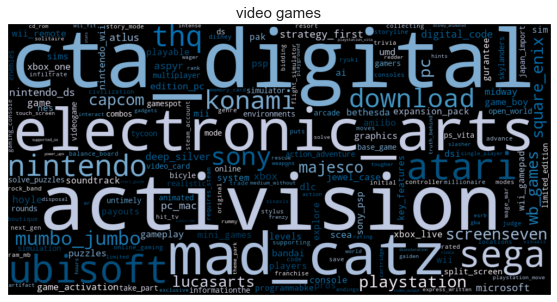

<IPython.core.display.Javascript object>

In [95]:
fig = plotting.wordcloud(
    coef.iloc[:, 36],
    cmap=np.random.choice(cmaps),
    size=(10, 5),
)